# Standard imports

In [1]:
import torch
import torchvision
import torchbearer

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import itertools

import os
import datetime

import glob
import matplotlib.pyplot as plt
import numpy as np

import livelossplot

import cure_dataset
import cure_models
import cure_utils

In [71]:
import importlib

In [72]:
importlib.reload(cure_utils)

<module 'cure_utils' from '/home/ubuntu/project/cure_utils.py'>

In [111]:
importlib.reload(cure_dataset)

<module 'cure_dataset' from '/home/ubuntu/project/cure_dataset.py'>

In [117]:
importlib.reload(cure_models)

<module 'cure_models' from '/home/ubuntu/project/cure_models.py'>

## Solve for means and standard deviations in the train dataset

In [4]:
# real and unreal data, challenge free
traindataset = cure_dataset.CURETSRDataset('../data', 'Train', '*', '00', '00', transform=None)

In [5]:
len(traindataset)

26902

In [11]:
running_mean = 0
count = 0
for image, label in traindataset:
    im = np.array(image)
    mean = np.mean(im, axis=(0,1))
    running_mean += mean
    count += 1
final_mean = running_mean / count

In [12]:
final_mean

array([98.64121395, 88.61250027, 93.19805106])

In [13]:
running_var = 0
count = 0
for image, label in traindataset:
    im = np.array(image)
    im[:,:,0] = im[:,:,0] - final_mean[0]
    im[:,:,1] = im[:,:,1] - final_mean[1]
    im[:,:,2] = im[:,:,2] - final_mean[2]

    avg_var = np.mean(im, axis=(0,1))
    running_var += avg_var
    count += 1
final_std = np.sqrt(running_var / count)

In [14]:
final_std

array([11.6151062 , 11.81852169, 11.821456  ])

In [15]:
# solved results for dataset mean and std
challenge_free_mean = [98.64121395, 88.61250027, 93.19805106]
challenge_free_std = [11.6151062 , 11.81852169, 11.821456  ]

## Setup Transforms based on training data stats

In [19]:
load_normalized = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(challenge_free_mean, challenge_free_std)
    ])

In [3]:
load_raw = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()])

# Train on clean data

In [28]:
# load real and unreal challenge free images 
testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '00', '00', transform=load_raw)
traindataset = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', '00', '00', transform=load_raw)

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=False, num_workers=0)


In [29]:
challenge_free_model = cure_models.ShallowNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(challenge_free_model.parameters(), lr=.01, amsgrad=True)

In [30]:
checkpoint_name = os.path.join('checkpoints', 'shallowCNN_challenge_free.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(challenge_free_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader
).cuda()

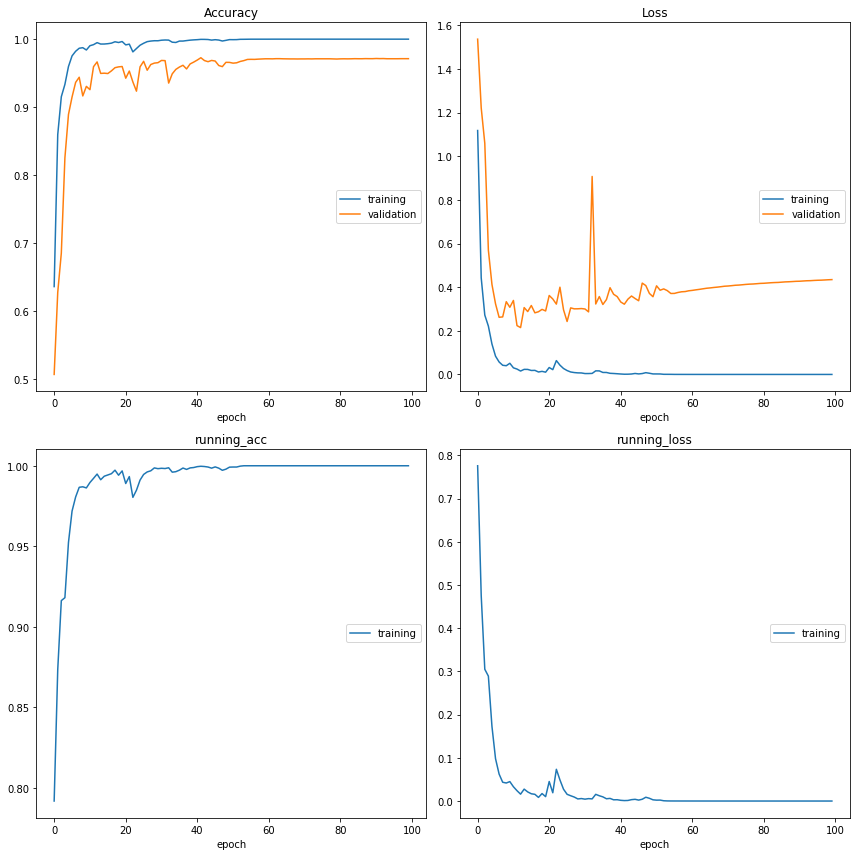

In [31]:
history = trial.run(epochs=100)

# Train on exposure data, all challenge levels

In [32]:
# load real and unreal challenge free images 
testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '06', '*', transform=load_raw)
traindataset = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', '06', '*', transform=load_raw)

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=False, num_workers=0)


In [33]:
len(testdataset), len(traindataset)

(57720, 134510)

In [34]:
exposure_all_model = cure_models.ShallowNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(exposure_all_model.parameters(), lr=.01, amsgrad=True)

In [36]:
checkpoint_name = os.path.join('checkpoints', 'shallowCNN_exposure_all.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(exposure_all_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader
).cuda()

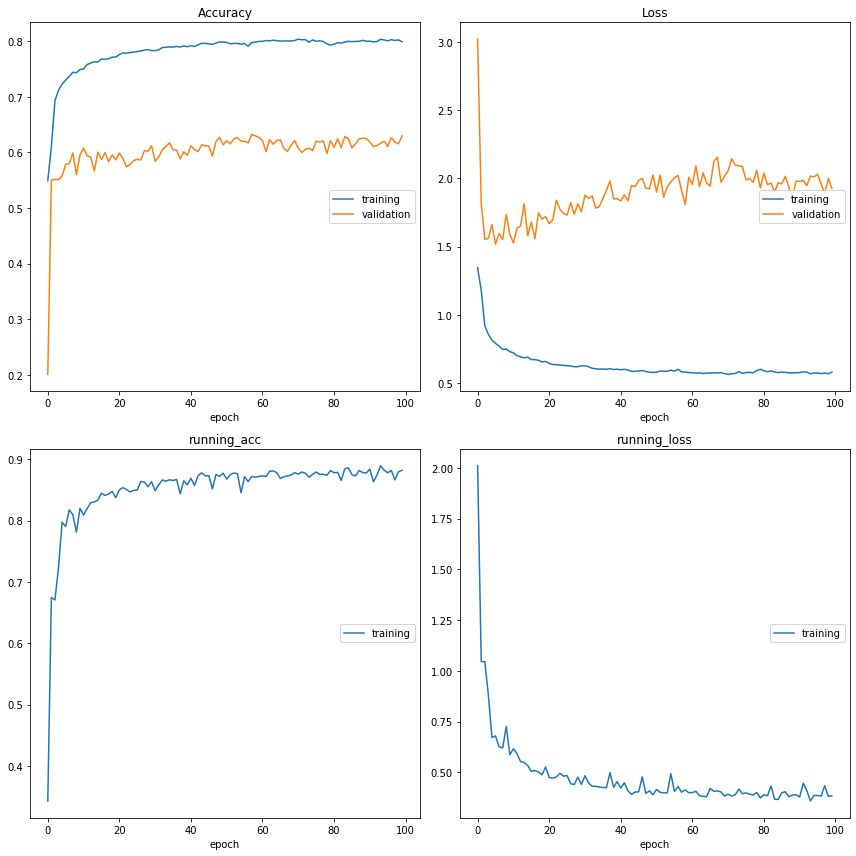

In [37]:
history = trial.run(epochs=100)

# Aside - train on only 3 easiest levels, test on all (want to see avg performance go up)

In [40]:
traindataset = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', '06', '0[0-3]', transform=load_raw)


In [44]:
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)

In [47]:
test2dataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '06', '0[0-3]', transform=load_raw)
test2loader = torch.utils.data.DataLoader(test2dataset, batch_size=256,
                                          shuffle=False, num_workers=0)

In [41]:
len(traindataset)

80706

In [42]:
exposure_0_3_model = cure_models.ShallowNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(exposure_0_3_model.parameters(), lr=.001, amsgrad=True)

In [48]:
checkpoint_name = os.path.join('checkpoints', 'shallowCNN_exposure_0_3.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(exposure_0_3_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader,
    test_generator=test2loader
).cuda()

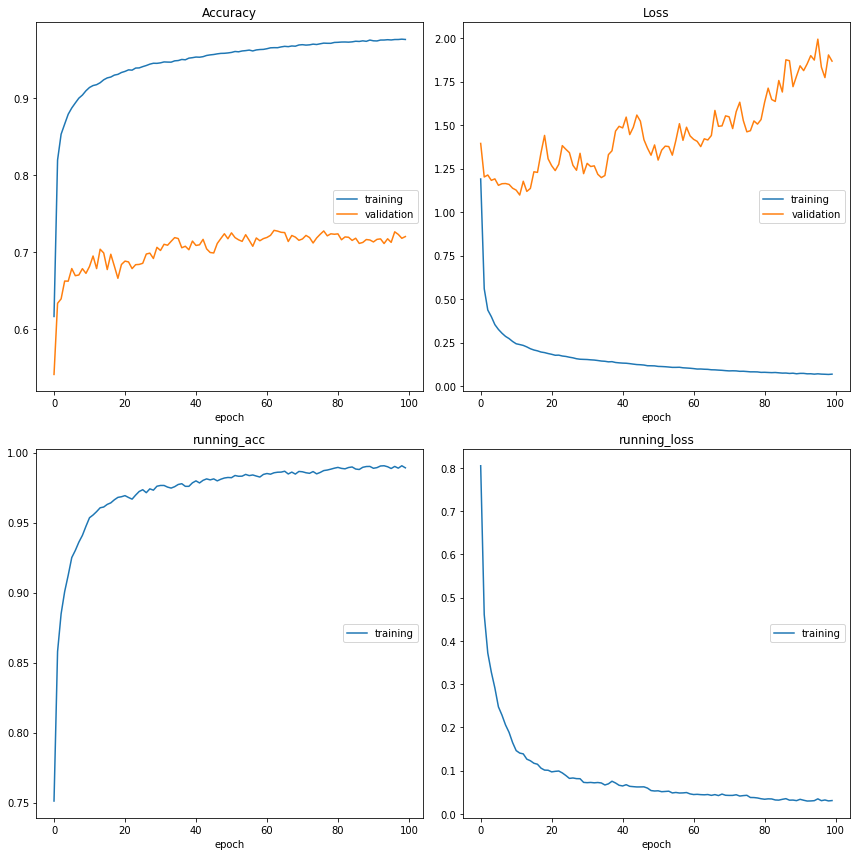

In [49]:
history = trial.run(epochs=100)

Confusion matrix, without normalization
[[2831  172   72    0   20    2    0   68  260  114   59   25  143   29]
 [ 537 1809  170    0    4    0    1    1  411   89   46    3   36   13]
 [ 439  193 1179    0    0    0    0    0  211  115   19    2   22    5]
 [ 207  249   13 3145  296    2    3    2  126  196   17   93   40   21]
 [ 500  104   10   34 3863    2   22   28  132  124   14   54   48   55]
 [  87   10    0    0   16 5110    0   47   67   18    5  455   52    3]
 [ 291   73    3    0  109    0 2185    4   41  135    8    1   47  633]
 [ 425   43   10    0   12    7    0 3355   67   89    0    4   23   20]
 [ 545  171   40    0   12    0    0    0 1793  302   57    3  115   57]
 [ 976  232  121    0   21    2    0   15  282 1976   20   12  119   29]
 [ 398  250   51    0    1    0    0    3  347  111  998    2   40   29]
 [  26    6    1    0   12  349    0   13   47   11    3  898   16    8]
 [ 592   91   10    0   24    0    0   21   29   78    2    2 3481   60]
 [ 884  488

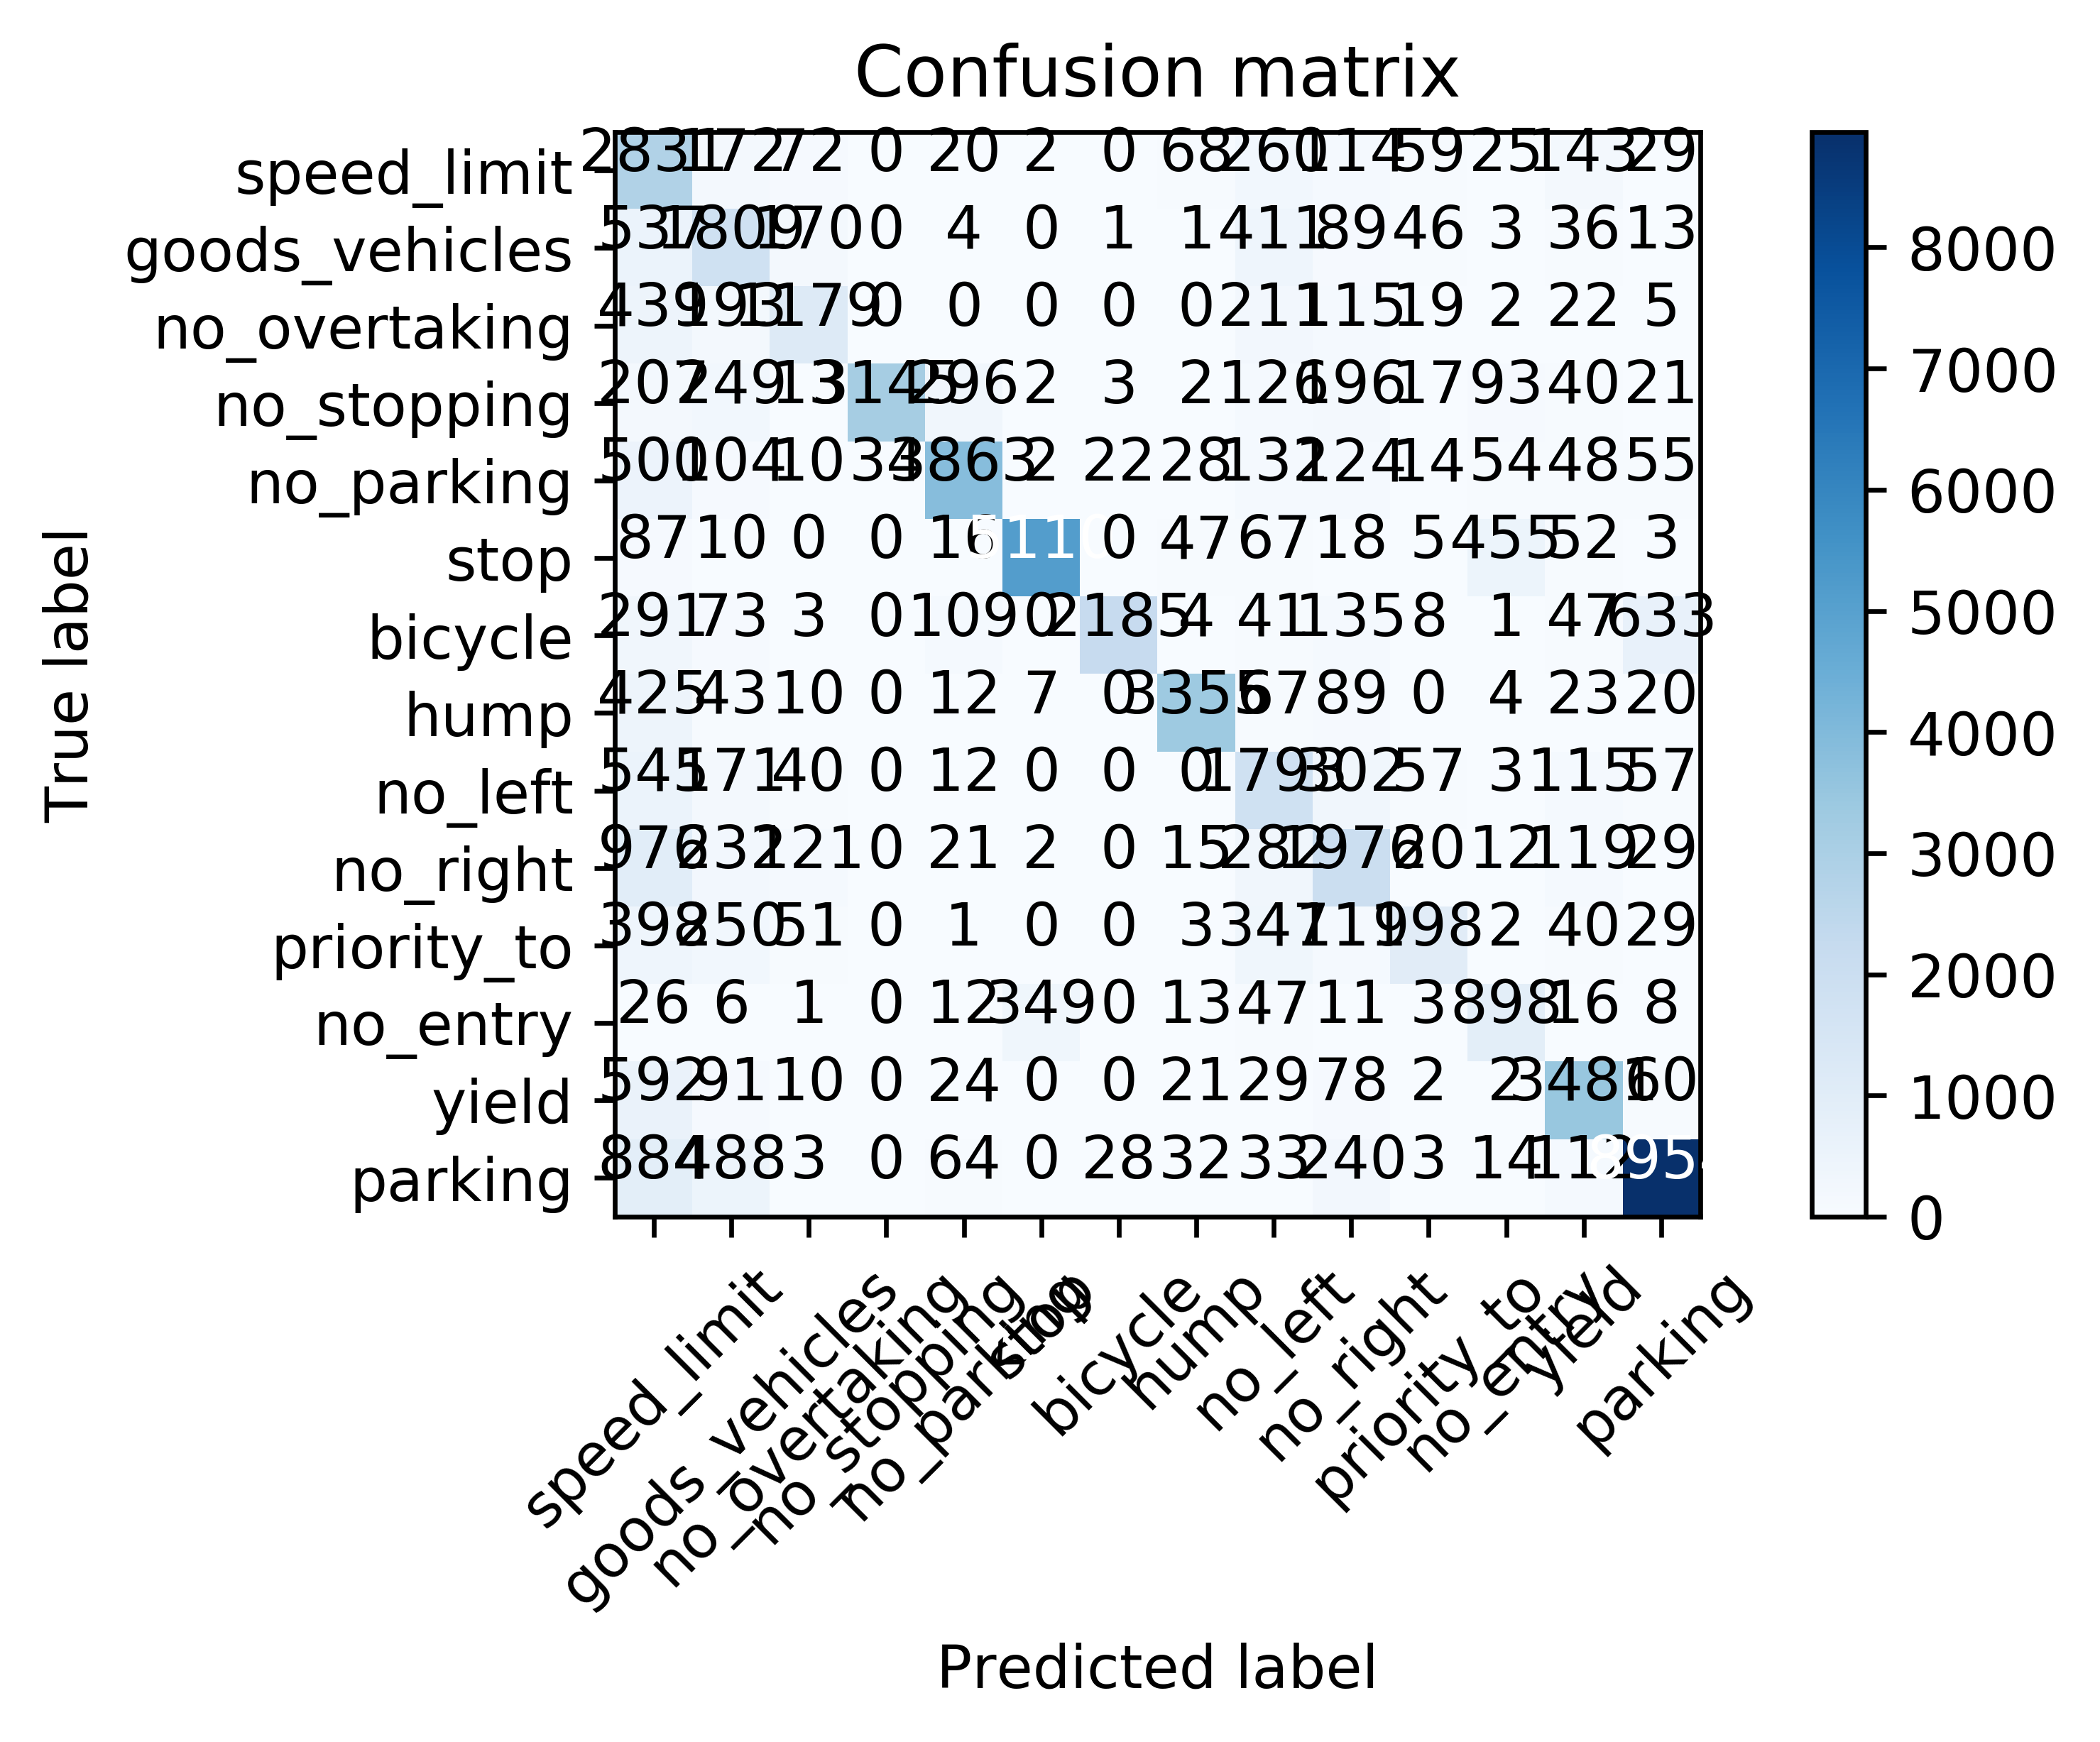

In [50]:
cure_utils.evaluate_model(exposure_0_3_model, testloader)

Confusion matrix, without normalization
[[1881   37   34    0    6    2    0   51  128   29   48    9   49    3]
 [  97 1496   35    0    1    0    1    1  206   19    7    2    3    4]
 [ 133   85  915    0    0    0    0    0  123   37    8    0    6    4]
 [   4   50    0 2378  181    0    2    1    1   15    2    6    2    4]
 [  27   31    0   28 2807    0   22    6    3   12    1   25    0   32]
 [   0    1    0    0    4 3425    0    2    2    1    0   78    8    1]
 [  27    5    0    0    1    0 1710    0   11   25    2    0   16  321]
 [ 114   12   10    0    0    3    0 2244    8   34    0    1    4    3]
 [ 165   78   26    0    0    0    0    0 1320  151   20    0   65   32]
 [ 349   57   35    0    5    2    0    8  173 1562   20    6   54   12]
 [  79  113   45    0    0    0    0    0  254   68  758    0   12    9]
 [   1    0    0    0    2  146    0    4   11    0    1  662    5    2]
 [  80   28    6    0   16    0    0   17   11   19    0    1 2429   27]
 [  39   58

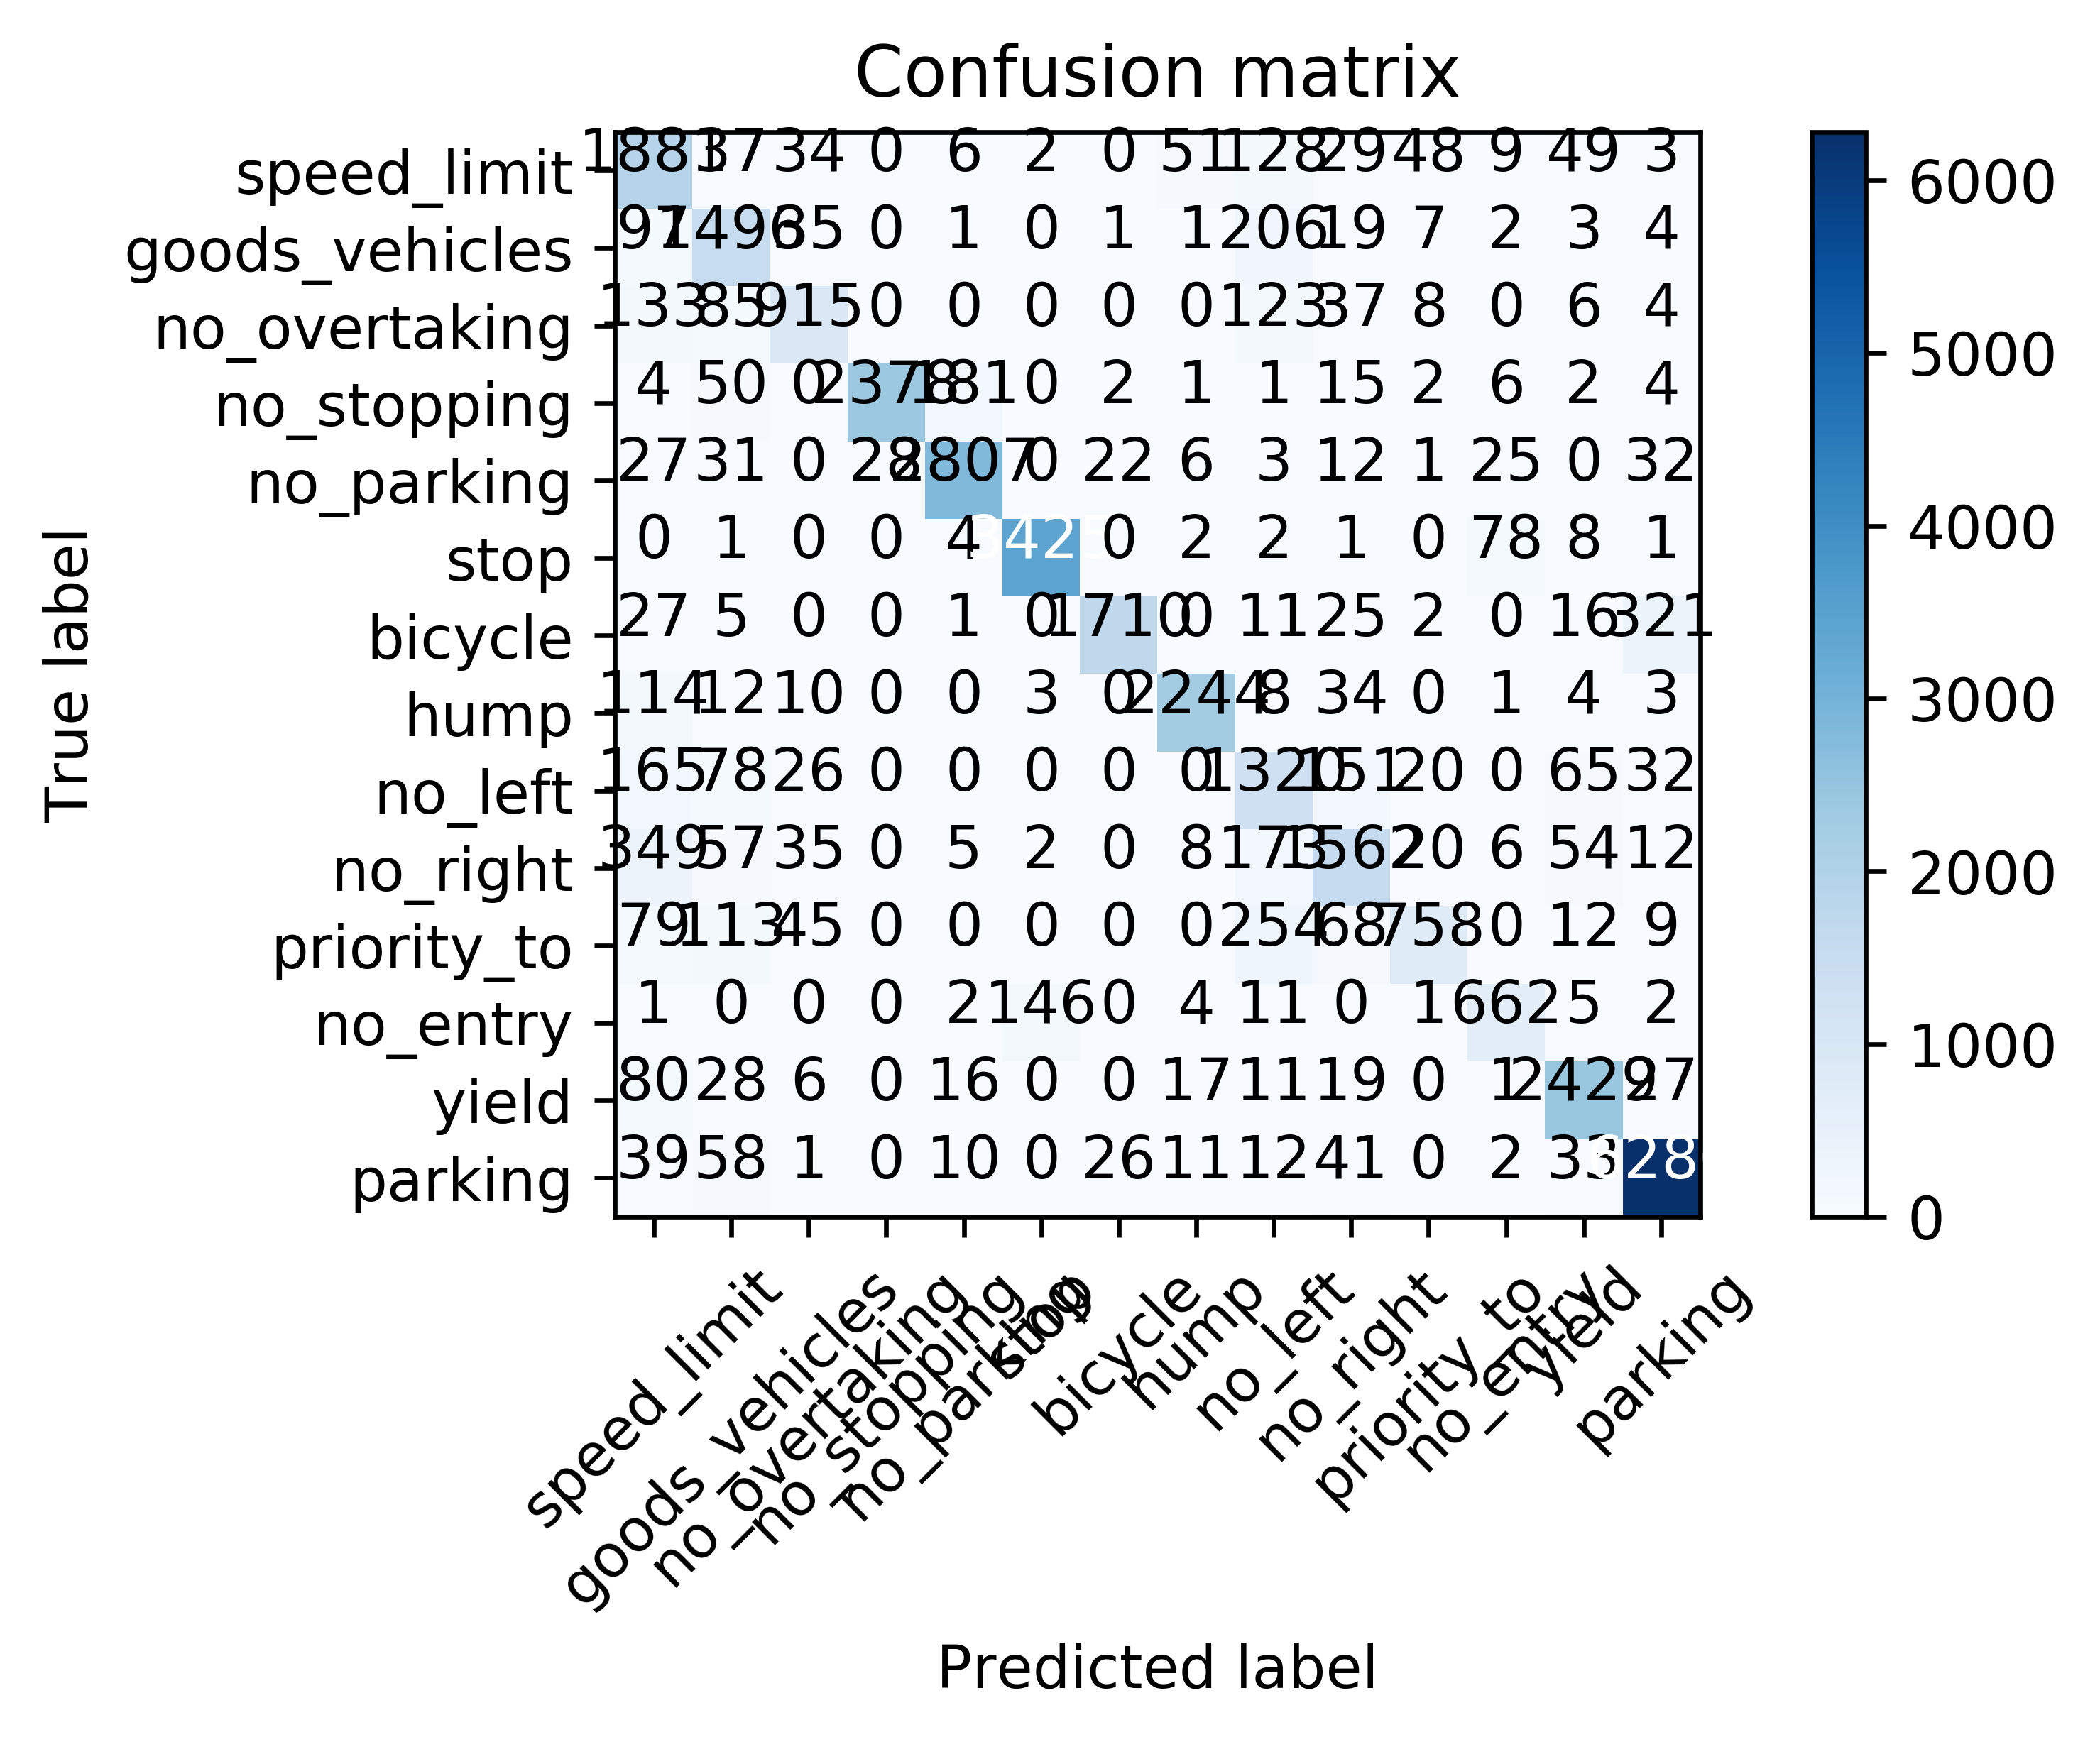

In [51]:
cure_utils.evaluate_model(exposure_0_3_model, test2loader)

### Note

Looks like an interesting finding - by training on only the first 3 challenge levels, I was able to get better performance on all 5 than when training on all 5

In [54]:
del(train2loader)

Confusion matrix, without normalization
[[2339  109    1    0  142    0    0    3   43  592   23    0   35  508]
 [ 512 1697  108    0   77    0    0    0    6  284    2    1   23  410]
 [ 557   81  865    0   29    0    0    0    5  389    9    0    6  244]
 [  40  113    0 1779   56    5   12   28   15 1674    7  168  282  231]
 [ 251  144    0    4 2640   17   49    9   44  833   19   52  162  766]
 [  23    9    0    1    1 3465    3  759    2   49    0 1093   45  420]
 [ 153   25    0    0  171    0 1285    2   58  298   41    0   49 1448]
 [ 610   87    5    0  278    2   16 1802  106  268  152    1  270  458]
 [ 428   50    0    0   15    0    0    0 1184  462   34    0   19  903]
 [ 642  138    0    0   57    0    1    9    6 2181   22    0  110  639]
 [ 488  205    0    0   73    0    0    0   12  374  788    0    2  288]
 [  27    5    0    0    2  415    3  199    6   24    3  546   17  143]
 [ 348   14    3    0   21    1    2   10   15  388   10    0 2887  691]
 [ 320  196

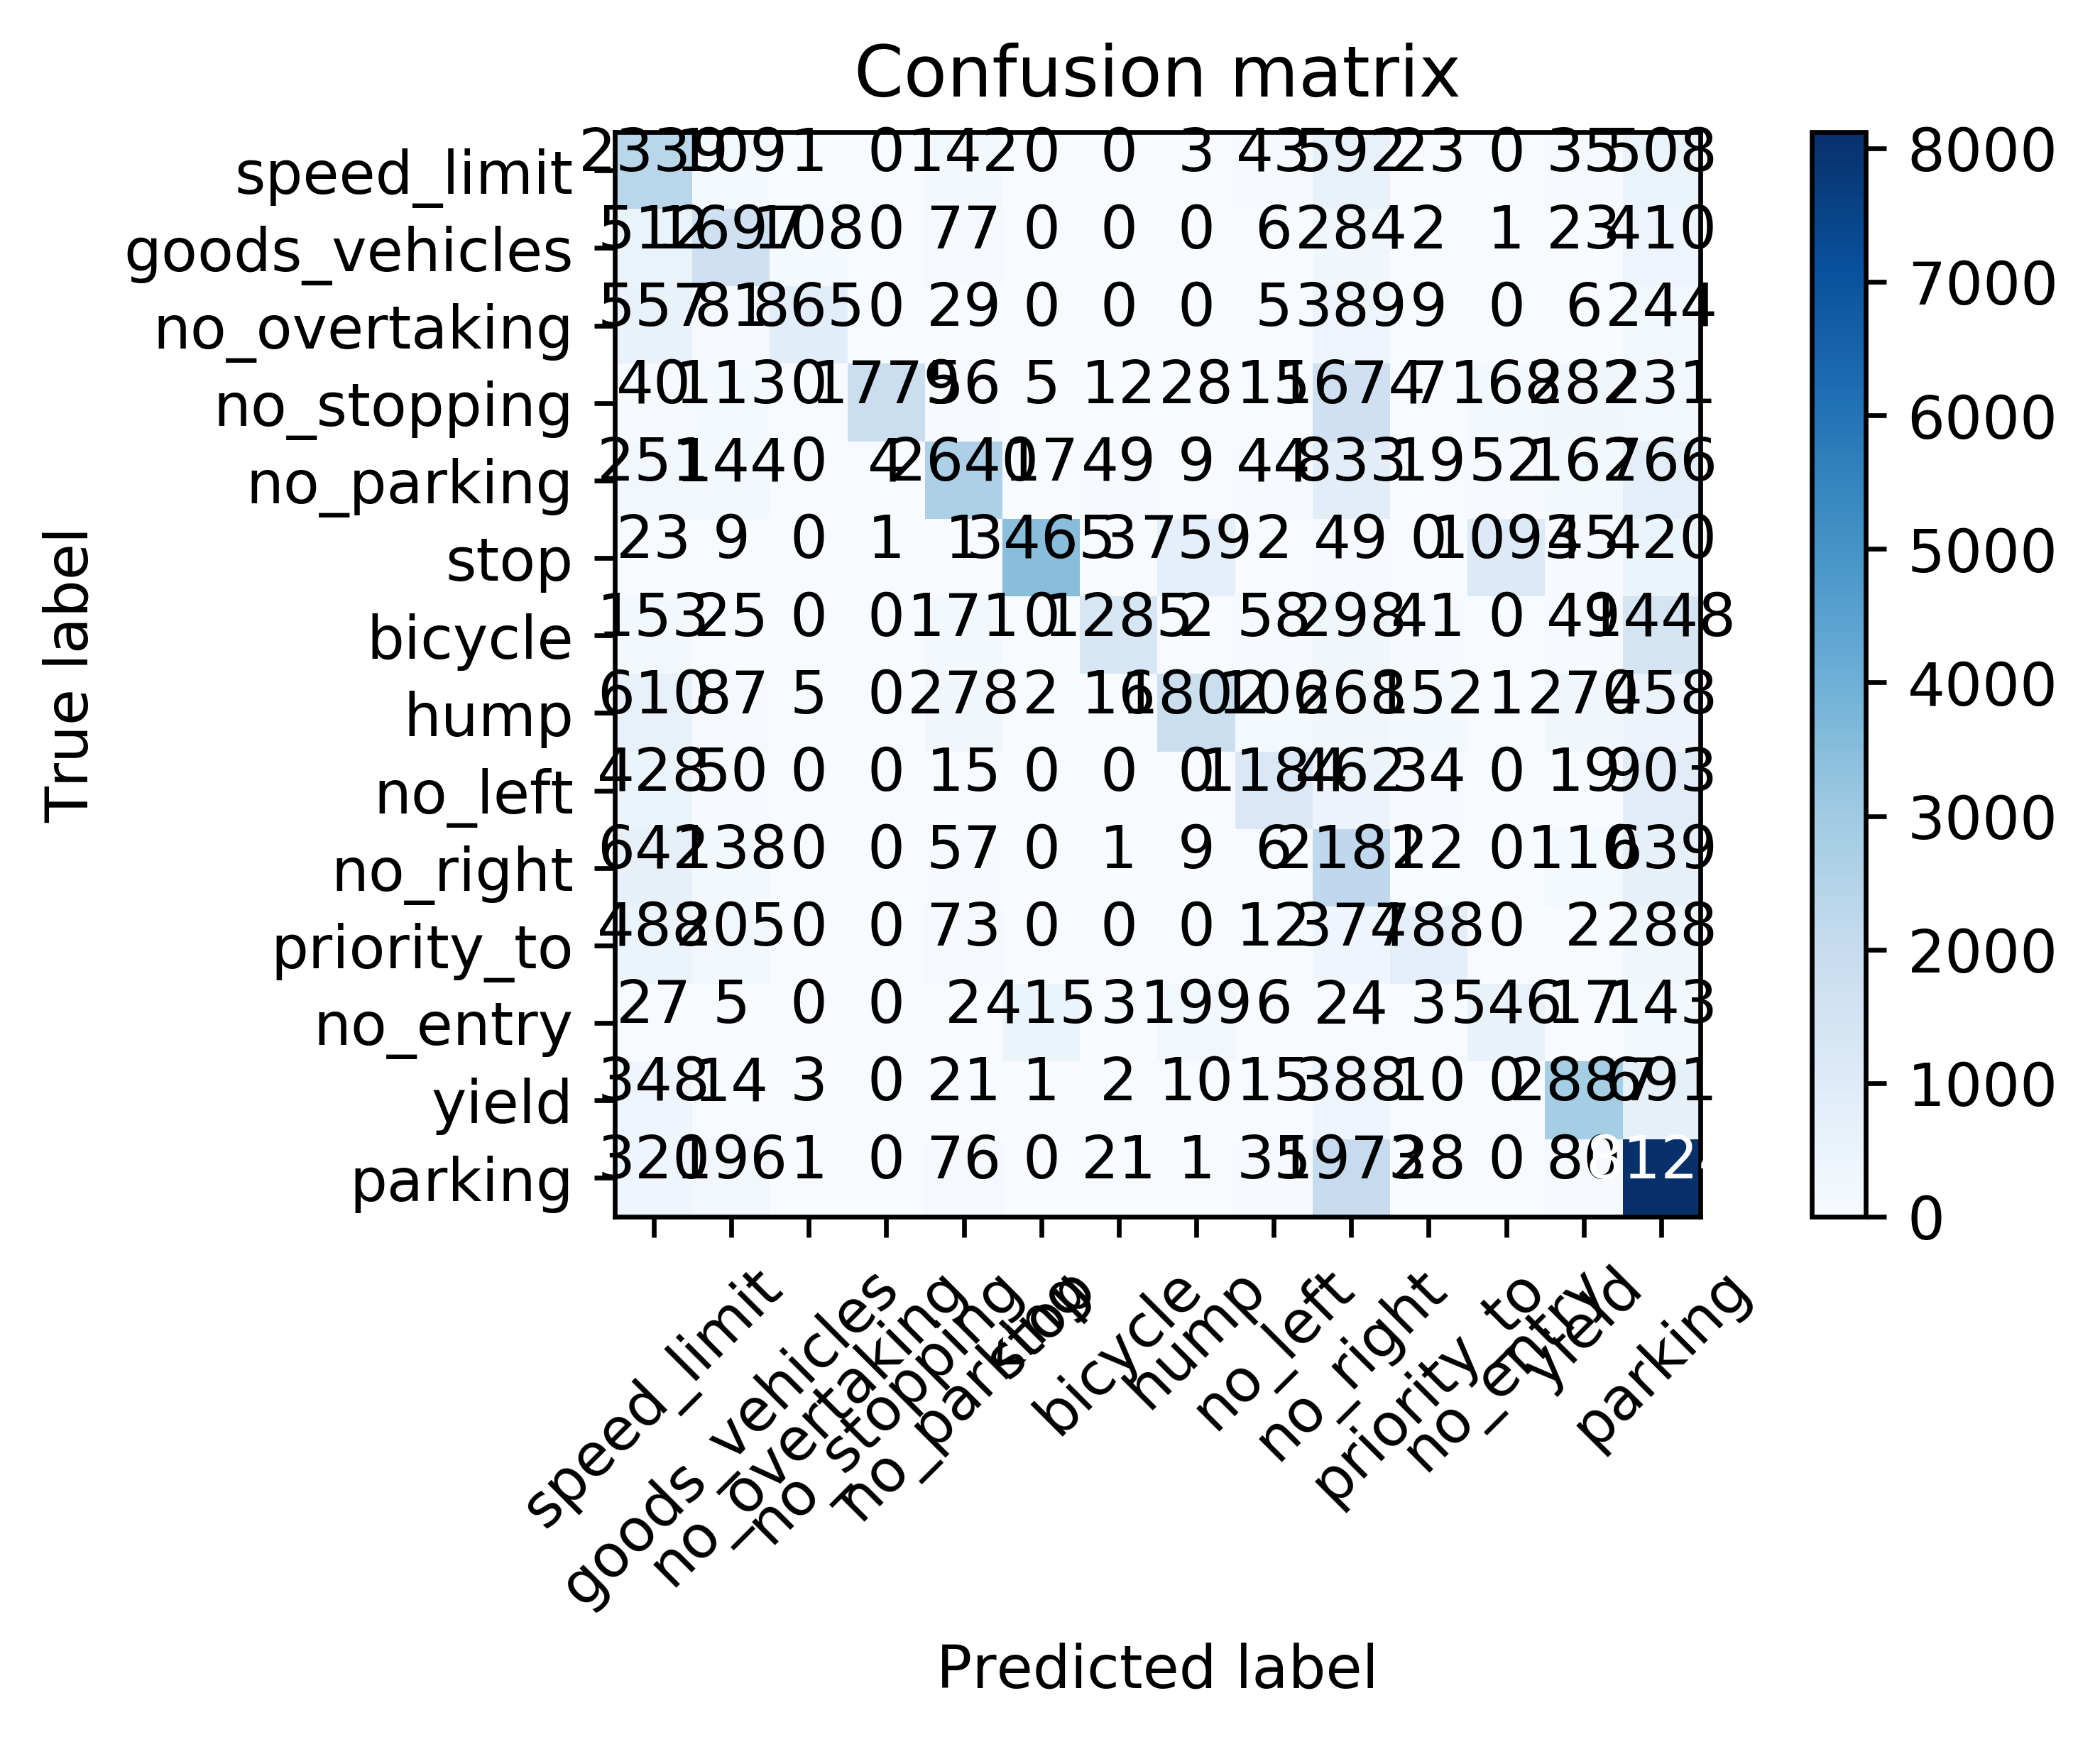

In [56]:
cure_utils.evaluate_model(challenge_free_model, testloader)

Confusion matrix, without normalization
[[1863   36    1    0  119    0    0    3    5  147   22    0   11   70]
 [ 277 1290   48    0   33    0    0    0    2  113    2    1   19   87]
 [ 375   25  744    0   23    0    0    0    1  109    9    0    1   24]
 [  13    6    0 1703   49    5    5   28    6  465    2  157  199    8]
 [  68   78    0    4 2379   15   49    4   11  150   10   49   24  153]
 [   1    1    0    1    0 2467    1  178    0    6    0  832   13   22]
 [  66   11    0    0  115    0 1171    2   11   73   17    0   17  635]
 [ 383   44    5    0  111    2    5 1486   45   87   69    0  120   76]
 [ 300   24    0    0   13    0    0    0  918  209   14    0   12  367]
 [ 507   77    0    0   18    0    1    9    5 1453   22    0   87  104]
 [ 377   67    0    0   41    0    0    0    1  164  658    0    0   30]
 [   2    1    0    0    2  229    0   76    0    0    0  490    1   33]
 [ 181    4    3    0    2    1    2    5    6  136    4    0 2121  169]
 [  72   75

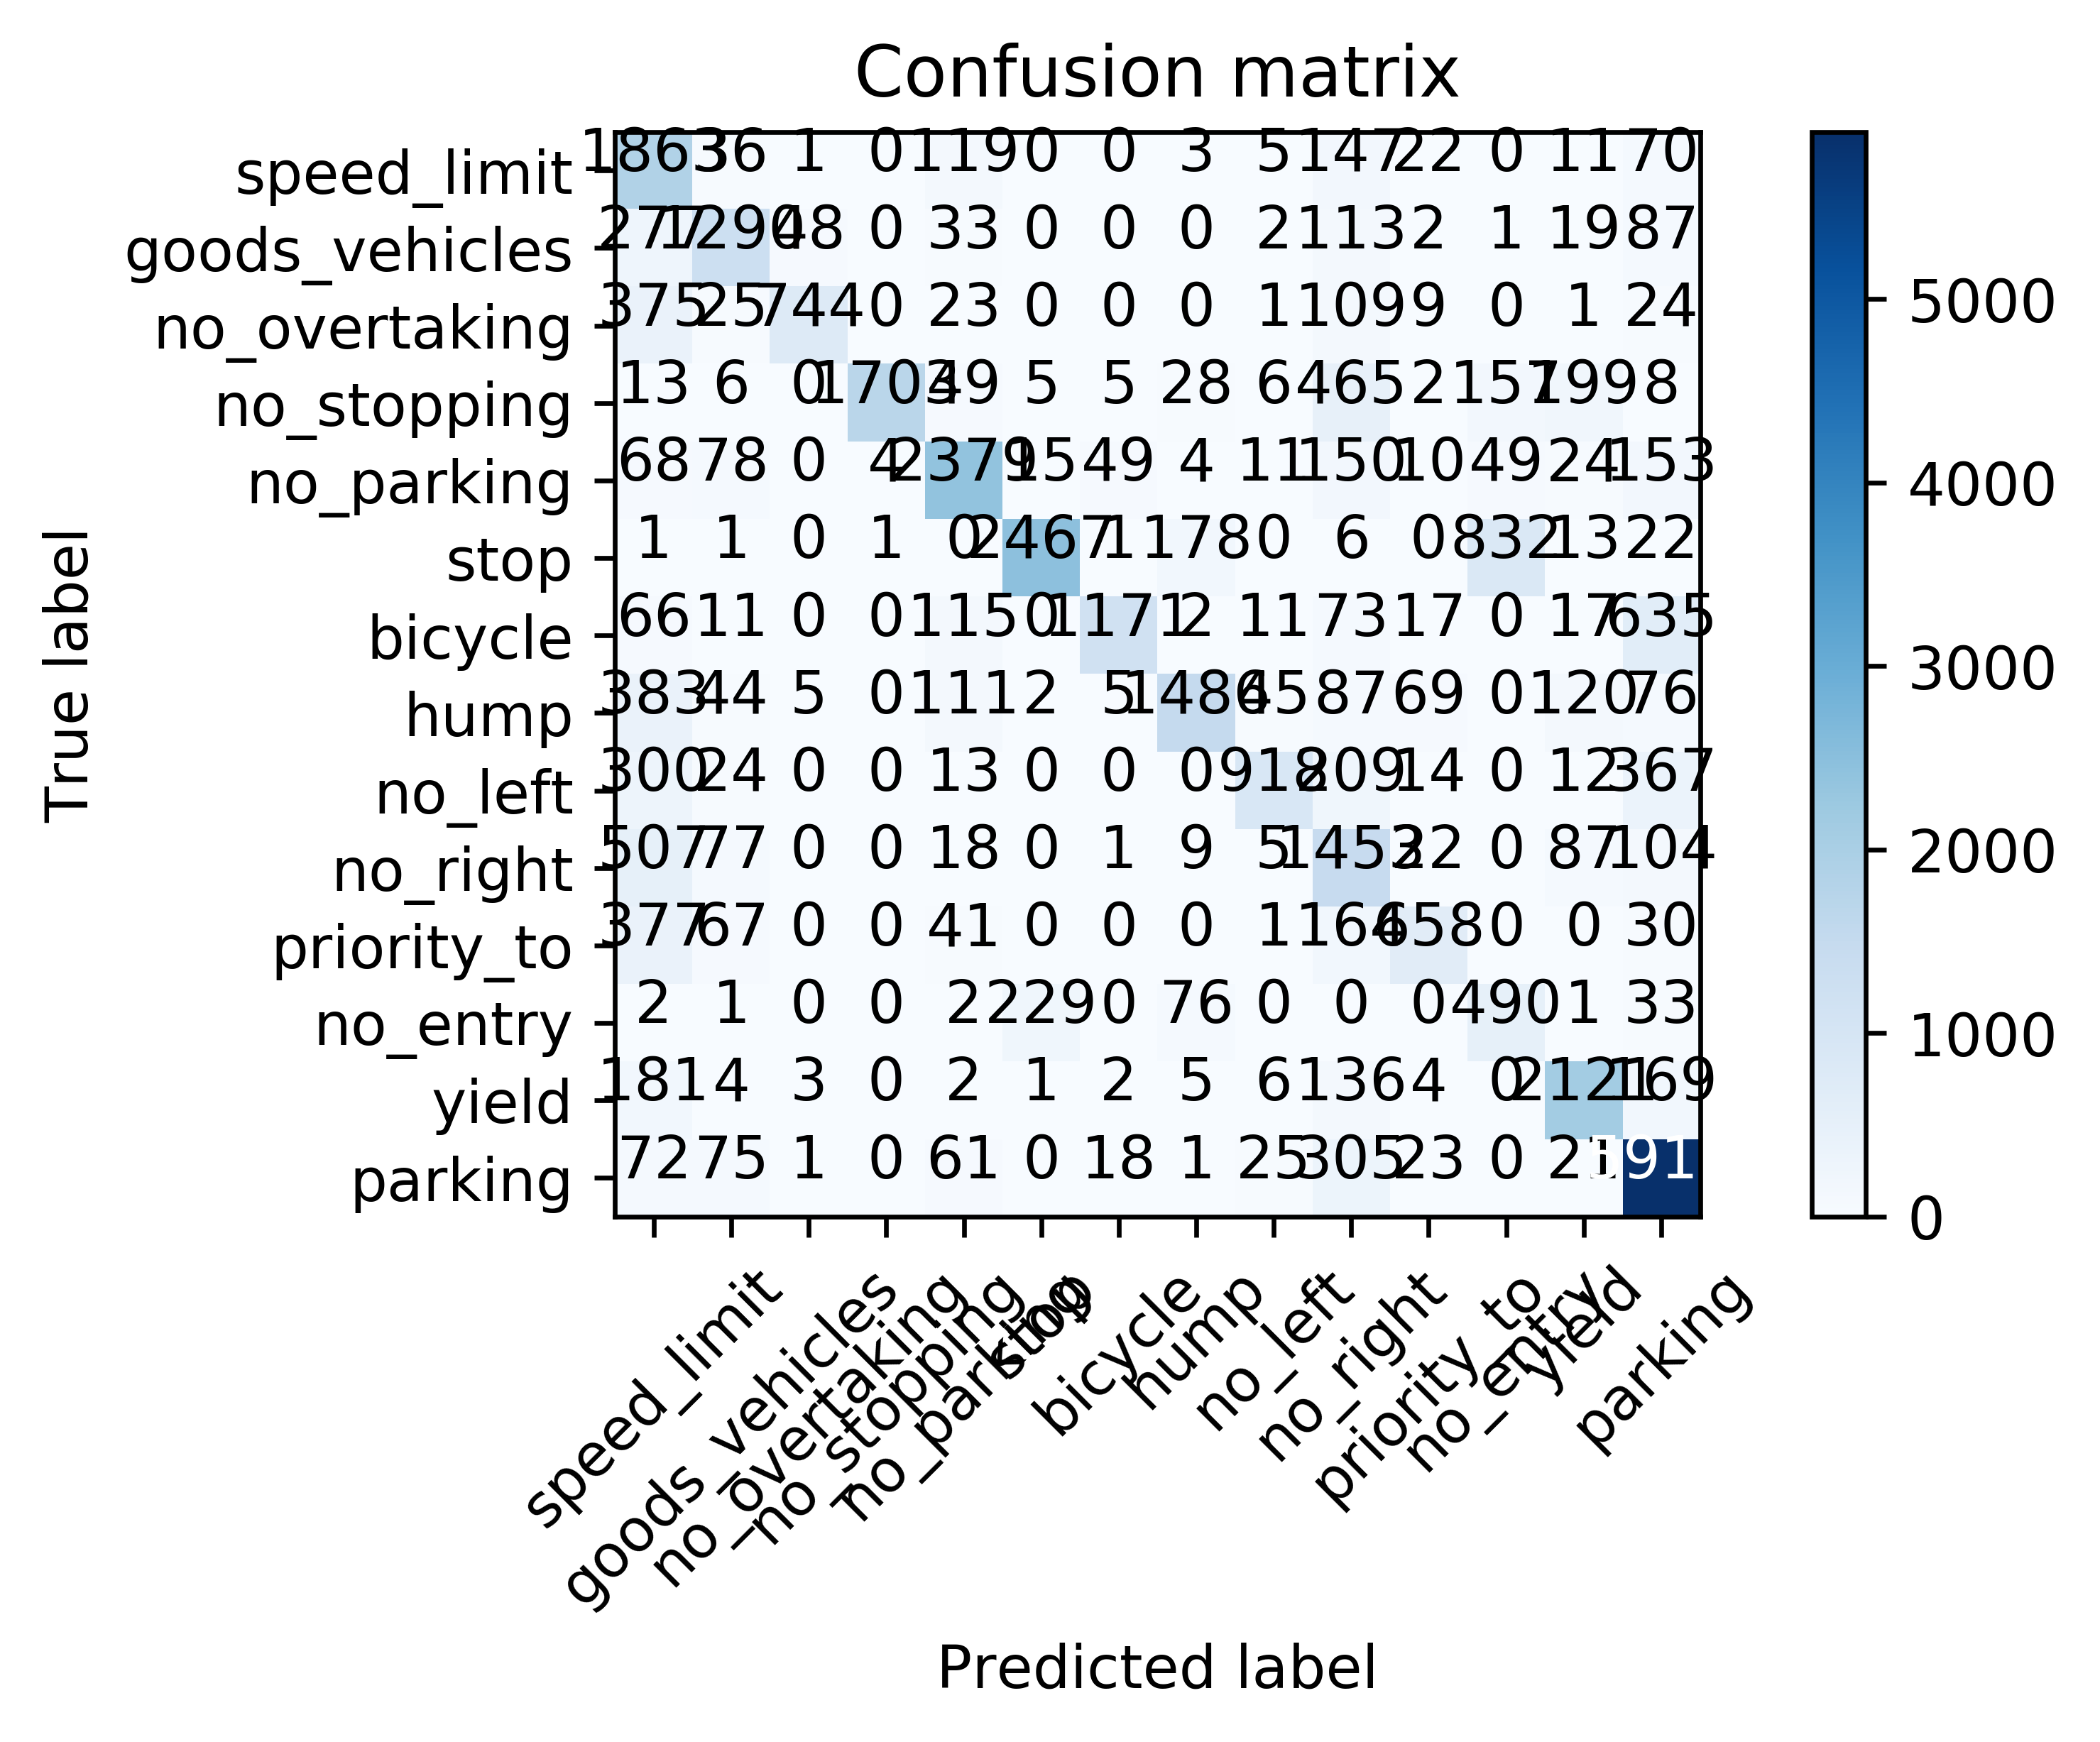

In [57]:
cure_utils.evaluate_model(challenge_free_model, test2loader)

# Classifiying Codec Error

In [58]:
# load real and unreal codec error data 
testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '03', '*', transform=load_raw)
traindataset = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', '03', '*', transform=load_raw)

testdataset2 = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '03', '0[0-3]', transform=load_raw)
traindataset2 = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', '03', '0[0-3]', transform=load_raw)

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=False, num_workers=0)

trainloader2 = torch.utils.data.DataLoader(traindataset2, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader2 = torch.utils.data.DataLoader(testdataset2, batch_size=512,
                                          shuffle=False, num_workers=0)


In [60]:
codec_error_all_model = cure_models.ShallowNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(codec_error_all_model.parameters(), lr=.001, amsgrad=True)

In [61]:
checkpoint_name = os.path.join('checkpoints', 'shallowCNN_codec_error_all.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(codec_error_all_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader,
).cuda()

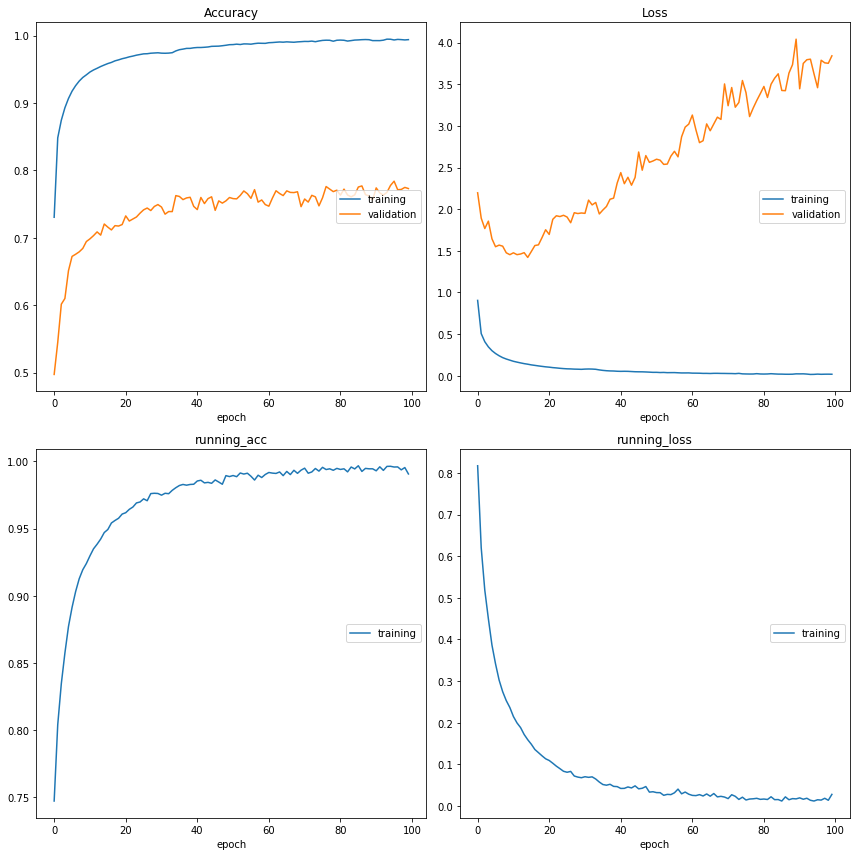

In [62]:
history = trial.run(epochs=100)

In [63]:
codec_error_1_3_model = cure_models.ShallowNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(codec_error_1_3_model.parameters(), lr=.001, amsgrad=True)

In [64]:
checkpoint_name = os.path.join('checkpoints', 'shallowCNN_codec_error_1_3.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(codec_error_1_3_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader2,
    val_generator=testloader,
).cuda()

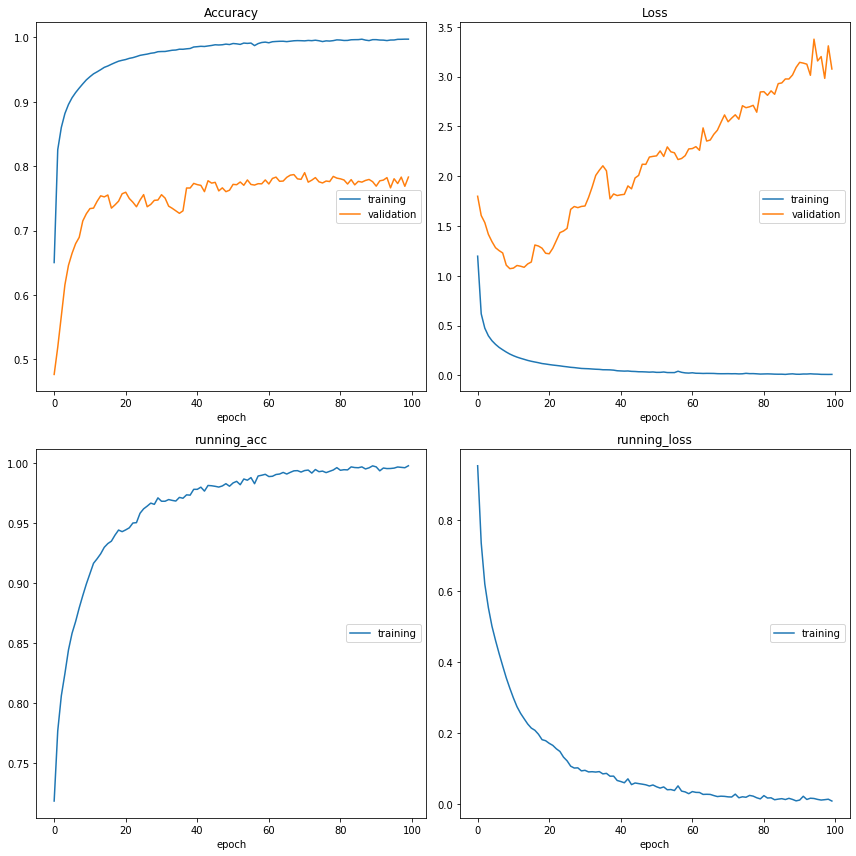

In [65]:
history = trial.run(epochs=100)

In [76]:
cure_utils.evaluate_model(challenge_free_model, testloader, False)

Accuracy of the network on the test images: 63.782 %
Accuracy of     0 (3795) : 53.439 %
Accuracy of     1 (3120) : 75.513 %
Accuracy of     2 (2185) : 59.497 %
Accuracy of     3 (4410) : 46.259 %
Accuracy of     4 (4990) : 57.856 %
Accuracy of     5 (5870) : 68.688 %
Accuracy of     6 (3530) : 23.513 %
Accuracy of     7 (4055) : 68.163 %
Accuracy of     8 (3095) : 65.267 %
Accuracy of     9 (3805) : 70.092 %
Accuracy of    10 (2230) : 73.812 %
Accuracy of    11 (1390) : 63.165 %
Accuracy of    12 (4390) : 69.681 %
Accuracy of    13 (10855) : 76.536 %


In [77]:
cure_utils.evaluate_model(challenge_free_model, testloader2, False)

Accuracy of the network on the test images: 68.249 %
Accuracy of     0 (2277) : 62.758 %
Accuracy of     1 (1872) : 77.831 %
Accuracy of     2 (1311) : 64.760 %
Accuracy of     3 (2646) : 49.773 %
Accuracy of     4 (2994) : 62.926 %
Accuracy of     5 (3522) : 75.894 %
Accuracy of     6 (2118) : 28.093 %
Accuracy of     7 (2433) : 71.804 %
Accuracy of     8 (1857) : 71.190 %
Accuracy of     9 (2283) : 76.040 %
Accuracy of    10 (1338) : 76.233 %
Accuracy of    11 (834) : 72.782 %
Accuracy of    12 (2634) : 71.526 %
Accuracy of    13 (6513) : 78.551 %


In [78]:
cure_utils.evaluate_model(codec_error_1_3_model, testloader, False)

Accuracy of the network on the test images: 78.300 %
Accuracy of     0 (3795) : 71.779 %
Accuracy of     1 (3120) : 79.167 %
Accuracy of     2 (2185) : 76.796 %
Accuracy of     3 (4410) : 60.000 %
Accuracy of     4 (4990) : 80.741 %
Accuracy of     5 (5870) : 90.102 %
Accuracy of     6 (3530) : 64.051 %
Accuracy of     7 (4055) : 81.677 %
Accuracy of     8 (3095) : 69.532 %
Accuracy of     9 (3805) : 72.037 %
Accuracy of    10 (2230) : 74.753 %
Accuracy of    11 (1390) : 80.935 %
Accuracy of    12 (4390) : 80.296 %
Accuracy of    13 (10855) : 88.217 %


In [79]:
cure_utils.evaluate_model(codec_error_1_3_model, testloader2, False)

Accuracy of the network on the test images: 81.835 %
Accuracy of     0 (2277) : 78.393 %
Accuracy of     1 (1872) : 82.746 %
Accuracy of     2 (1311) : 81.083 %
Accuracy of     3 (2646) : 64.588 %
Accuracy of     4 (2994) : 85.070 %
Accuracy of     5 (3522) : 92.589 %
Accuracy of     6 (2118) : 67.517 %
Accuracy of     7 (2433) : 85.450 %
Accuracy of     8 (1857) : 75.283 %
Accuracy of     9 (2283) : 77.617 %
Accuracy of    10 (1338) : 77.578 %
Accuracy of    11 (834) : 83.094 %
Accuracy of    12 (2634) : 82.916 %
Accuracy of    13 (6513) : 89.559 %


# Classifiying Lens Blur

In [80]:
# load real and unreal lens blur 
testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '02', '*', transform=load_raw)
traindataset = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', '02', '*', transform=load_raw)

testdataset2 = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '02', '0[0-3]', transform=load_raw)
traindataset2 = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', '02', '0[0-3]', transform=load_raw)

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=False, num_workers=0)

trainloader2 = torch.utils.data.DataLoader(traindataset2, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader2 = torch.utils.data.DataLoader(testdataset2, batch_size=512,
                                          shuffle=False, num_workers=0)


In [89]:
lens_blur_all_model = cure_models.ShallowNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lens_blur_all_model.parameters(), lr=.001, amsgrad=True)

In [91]:
checkpoint_name = os.path.join('checkpoints', 'shallowCNN_lens_blur_all_cont.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(lens_blur_all_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader,
).cuda()

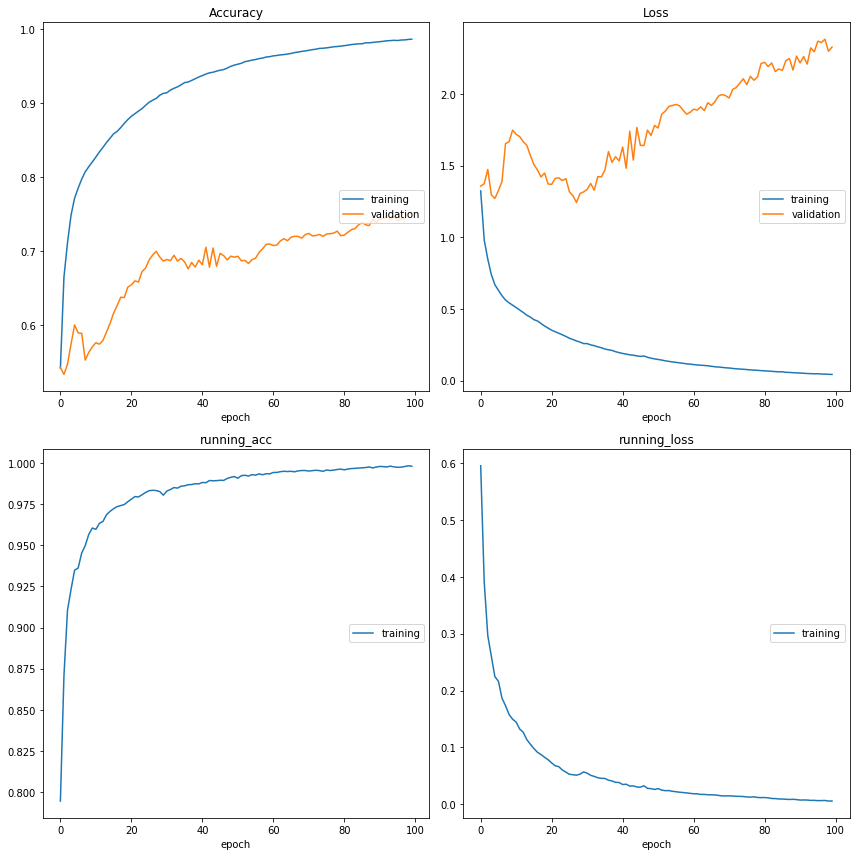

In [84]:
history = trial.run(epochs=100)

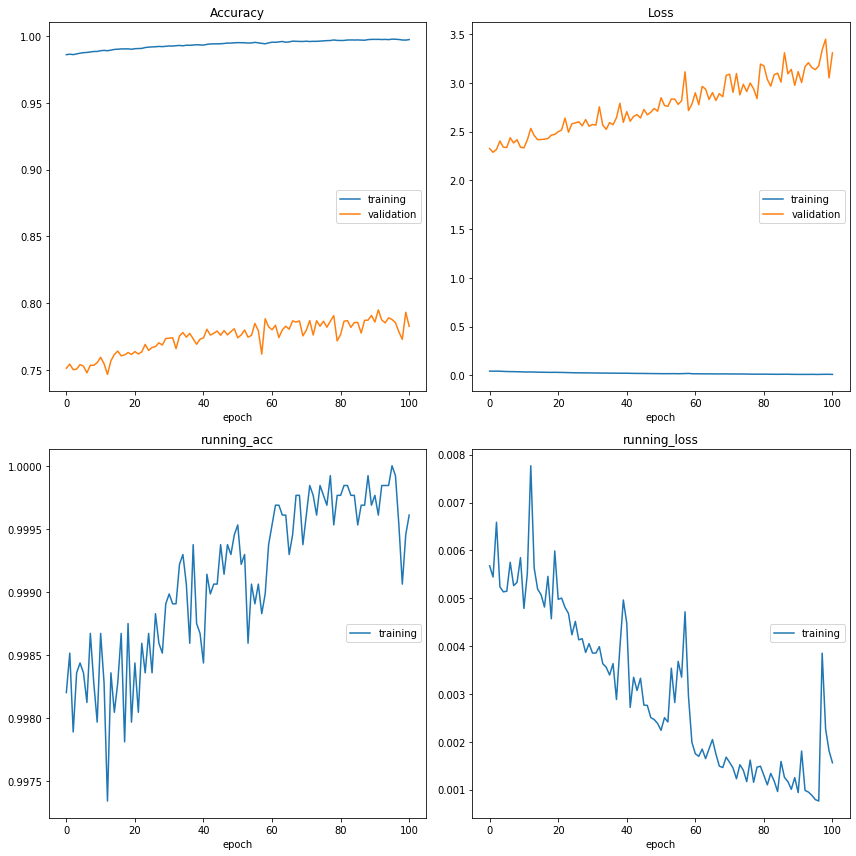

[{'running_acc': 0.7944530844688416,
  'running_loss': 0.5953166484832764,
  'acc': 0.542585551738739,
  'loss': 1.322974681854248,
  'val_acc': 0.5433818697929382,
  'val_loss': 1.3555207252502441,
  'train_steps': 449,
  'validation_steps': 113},
 {'running_acc': 0.8705468773841858,
  'running_loss': 0.390561044216156,
  'acc': 0.6650594472885132,
  'loss': 0.9805994033813477,
  'val_acc': 0.5339916944503784,
  'val_loss': 1.3737239837646484,
  'train_steps': 449,
  'validation_steps': 113},
 {'running_acc': 0.9104687571525574,
  'running_loss': 0.2967546284198761,
  'acc': 0.7113526463508606,
  'loss': 0.8472785949707031,
  'val_acc': 0.5477650761604309,
  'val_loss': 1.4727774858474731,
  'train_steps': 449,
  'validation_steps': 113},
 {'running_acc': 0.9232031106948853,
  'running_loss': 0.2602769732475281,
  'acc': 0.7488032579421997,
  'loss': 0.7392410635948181,
  'val_acc': 0.574930727481842,
  'val_loss': 1.2950496673583984,
  'train_steps': 449,
  'validation_steps': 113},


In [92]:
# looks like it might still have something to gain, so I am going to let it keep training

trial.load_state_dict(torch.load('checkpoints/shallowCNN_lens_blur_all.98-0.752.pt'))
trial = trial.cuda()

trial.run(epochs=200)


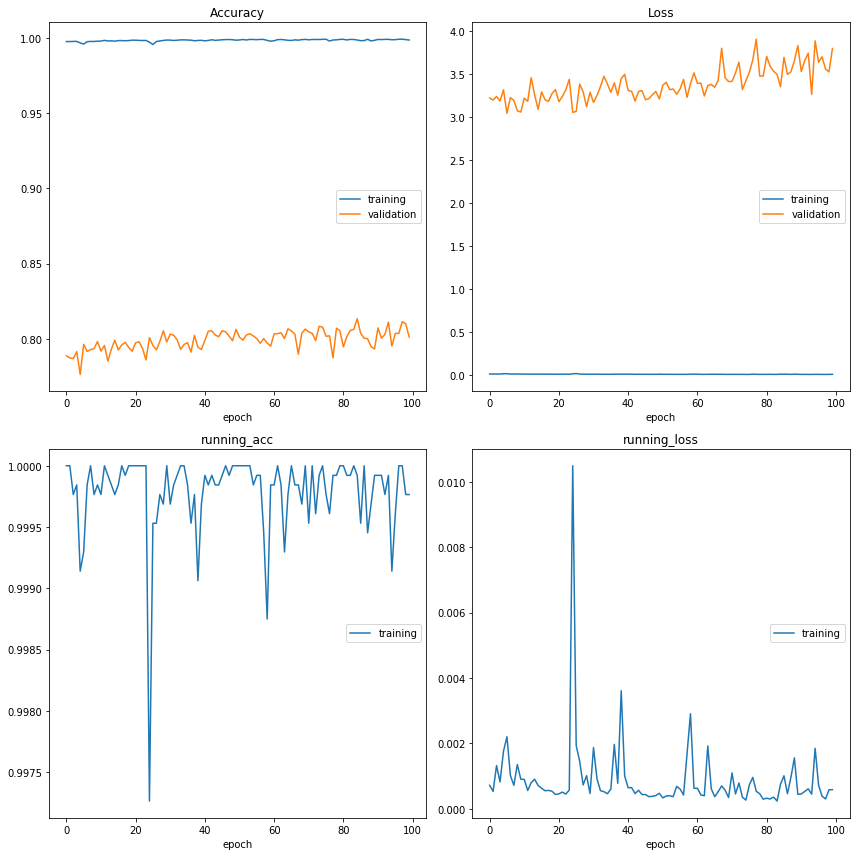

In [93]:
history = trial.run(epochs=300)

In [85]:
lens_blur_1_3_model = cure_models.ShallowNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lens_blur_1_3_model.parameters(), lr=.001, amsgrad=True)

In [87]:
checkpoint_name = os.path.join('checkpoints', 'shallowCNN_lens_blur_1_3.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(lens_blur_1_3_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader2,
    val_generator=testloader,
).cuda()

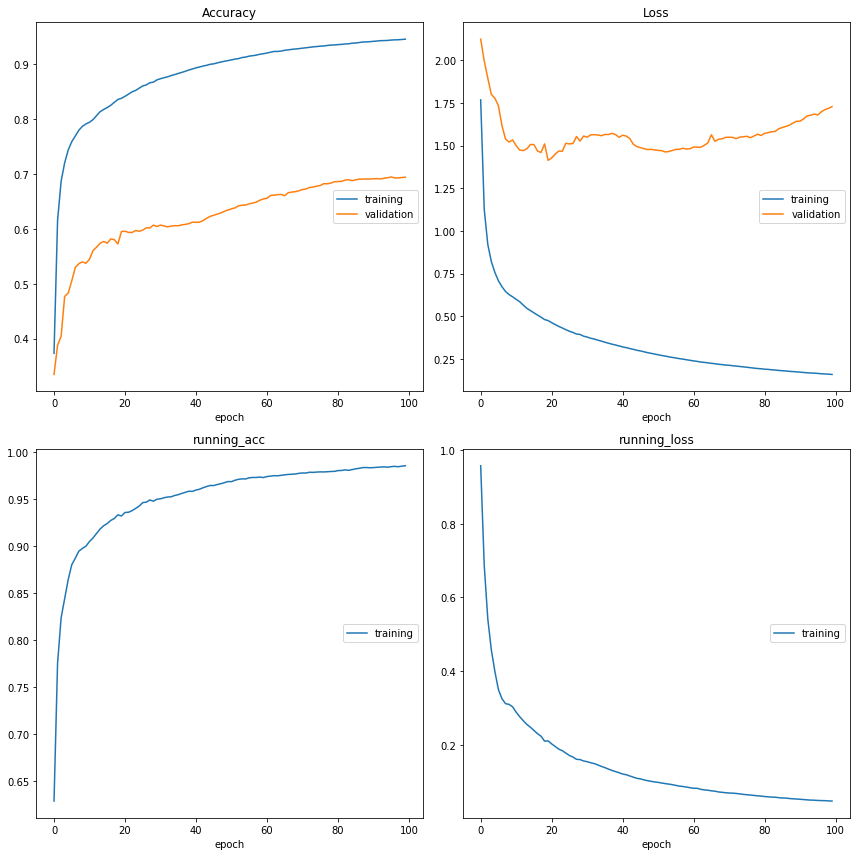

In [88]:
history = trial.run(epochs=100)

# Training the overall network (First attempt)

In [96]:
del(testdataset); del(traindataset); del(testdataset2); del(traindataset2)
del(trainloader); del(testloader); del(trainloader2); del(testloader2)

In [112]:
%%time
# load all four noise classes (none, exposure, codec error, lens blur)
testdataset_paths = cure_dataset.CURETSRDataset('../data', 'Test', '*', '00', '*', transform=load_raw).paths + \
                    cure_dataset.CURETSRDataset('../data', 'Test', '*', '02', '*', transform=load_raw).paths + \
                    cure_dataset.CURETSRDataset('../data', 'Test', '*', '03', '*', transform=load_raw).paths + \
                    cure_dataset.CURETSRDataset('../data', 'Test', '*', '06', '*', transform=load_raw).paths
            
traindataset_paths = cure_dataset.CURETSRDataset('../data', 'Train', '*', '00', '*', transform=load_raw).paths + \
                     cure_dataset.CURETSRDataset('../data', 'Train', '*', '02', '*', transform=load_raw).paths + \
                     cure_dataset.CURETSRDataset('../data', 'Train', '*', '03', '*', transform=load_raw).paths + \
                     cure_dataset.CURETSRDataset('../data', 'Train', '*', '06', '*', transform=load_raw).paths

            
testdataset = cure_dataset.CURETSRDatasetCached('', '', '', '', '', fromPaths=testdataset_paths, transform=load_raw)          
traindataset = cure_dataset.CURETSRDatasetCached('', '', '', '', '', fromPaths=traindataset_paths, transform=load_raw)          


trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=False, num_workers=0)


CPU times: user 2min 34s, sys: 10.6 s, total: 2min 44s
Wall time: 2min 44s


In [114]:
len(testdataset), len(traindataset)

(184704, 410820)

In [245]:
importlib.reload(cure_models)

<module 'cure_models' from '/home/ubuntu/project/cure_models.py'>

In [253]:
mix_of_experts_model = cure_models.GroupOfExpertsShallowNetwork()

In [254]:
mix_of_experts_model.challenge_free.load_state_dict(torch.load('checkpoints/shallowCNN_challenge_free.41-0.973.pt')['model'], strict=False)
mix_of_experts_model.exposure.load_state_dict(torch.load('checkpoints/shallowCNN_exposure_0_3.62-0.728.pt')['model'], strict=False)
mix_of_experts_model.codec_error.load_state_dict(torch.load('checkpoints/shallowCNN_codec_error_1_3.70-0.790.pt')['model'], strict=False)
mix_of_experts_model.lens_blur.load_state_dict(torch.load('checkpoints/shallowCNN_lens_blur_all_cont.284-0.813.pt')['model'], strict=False)


<All keys matched successfully>

In [255]:
for m in [mix_of_experts_model.challenge_free, mix_of_experts_model.exposure, mix_of_experts_model.codec_error, mix_of_experts_model.lens_blur]:
    for p in m.parameters():
        p.requires_grad = False

In [256]:
mix_of_experts_model = mix_of_experts_model.cuda()

In [257]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mix_of_experts_model.parameters(), lr=.01)

In [258]:
checkpoint_name = os.path.join('checkpoints', 'mix_of_experts.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(mix_of_experts_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader,
).cuda()

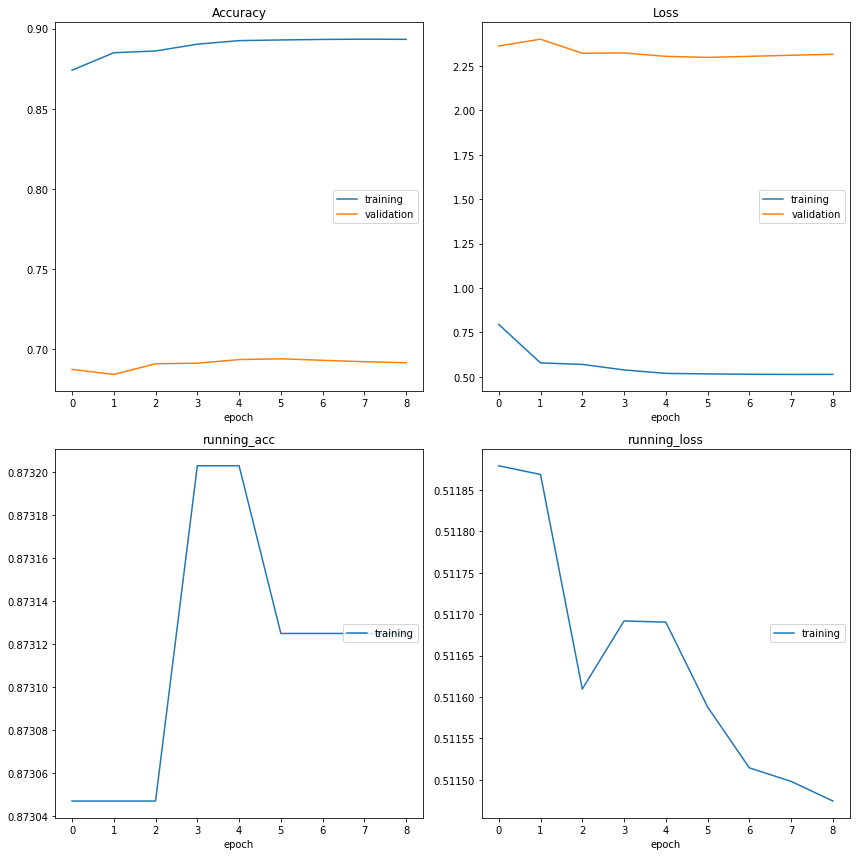

/home/ubuntu/project/cure_models.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  gate_weights = F.softmax(self.gating_network(x)).reshape(-1,4,1).expand_as(intermediate) # n,4


KeyboardInterrupt: 

In [259]:
history = trial.run(epochs=100)

### Note

This really doens't seem to be training well - I think I will try training the gating network directly

# Gating network direct training

In [4]:
%%time
# load gating network data

testdataset_paths = cure_dataset.CURETSRDataset('../data', 'Test', '*', '00', '*', transform=load_raw).paths + \
                    cure_dataset.CURETSRDataset('../data', 'Test', '*', '02', '*', transform=load_raw).paths + \
                    cure_dataset.CURETSRDataset('../data', 'Test', '*', '03', '*', transform=load_raw).paths + \
                    cure_dataset.CURETSRDataset('../data', 'Test', '*', '06', '*', transform=load_raw).paths
            
traindataset_paths = cure_dataset.CURETSRDataset('../data', 'Train', '*', '00', '*', transform=load_raw).paths + \
                     cure_dataset.CURETSRDataset('../data', 'Train', '*', '02', '*', transform=load_raw).paths + \
                     cure_dataset.CURETSRDataset('../data', 'Train', '*', '03', '*', transform=load_raw).paths + \
                     cure_dataset.CURETSRDataset('../data', 'Train', '*', '06', '*', transform=load_raw).paths

            
testdataset = cure_dataset.CURETSRDataset_Noise_Cached('', '', '', '', '', fromPaths=testdataset_paths, transform=load_raw)          
traindataset = cure_dataset.CURETSRDataset_Noise_Cached('', '', '', '', '', fromPaths=traindataset_paths, transform=load_raw)          


trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=True, num_workers=0)


CPU times: user 2min 47s, sys: 37.1 s, total: 3min 24s
Wall time: 8min 38s


In [6]:
gating_network_model = cure_models.GatingNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gating_network_model.parameters(), lr=.001, amsgrad=True)

In [7]:
checkpoint_name = os.path.join('checkpoints', 'gating_network.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(gating_network_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader,
).cuda()

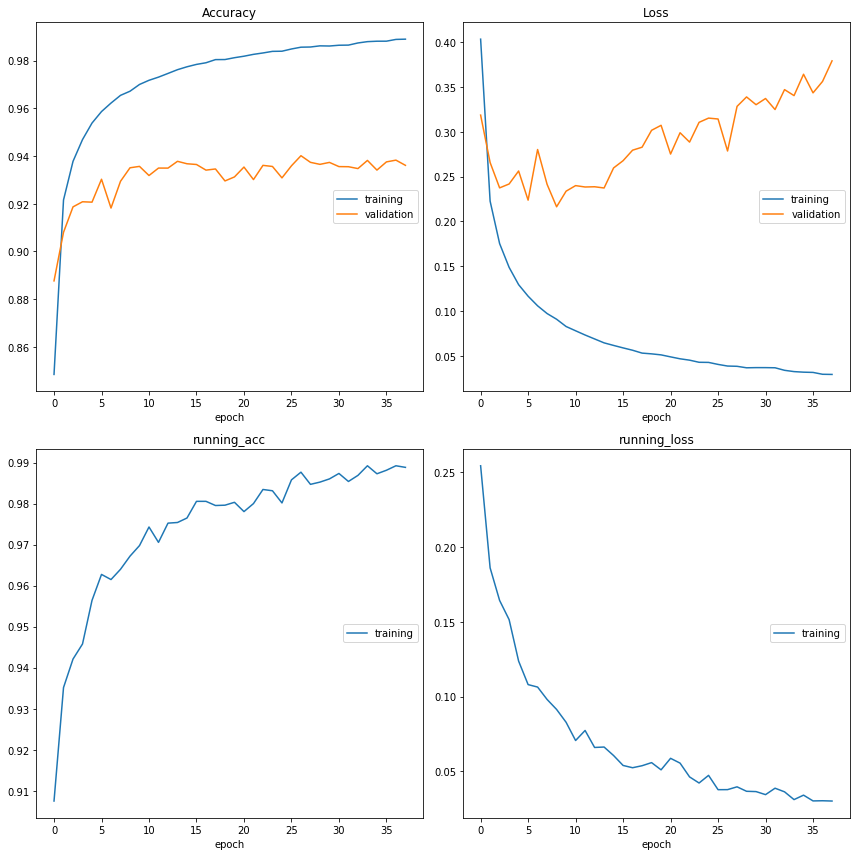

KeyboardInterrupt: 

In [8]:
history = trial.run(epochs=100)

Confusion matrix, without normalization
[[ 7584  1678  1644   638]
 [  692 56175   782    71]
 [ 2330  1552 52941   897]
 [  735   563   489 55933]]
Accuracy of the network on the test images: 93.465 %
Accuracy of     0 (11544) : 65.696 %
Accuracy of     1 (57720) : 97.323 %
Accuracy of     2 (57720) : 91.720 %
Accuracy of     3 (57720) : 96.904 %
Accuracy of     4 (0): N/A
Accuracy of     5 (0): N/A
Accuracy of     6 (0): N/A
Accuracy of     7 (0): N/A
Accuracy of     8 (0): N/A
Accuracy of     9 (0): N/A
Accuracy of    10 (0): N/A
Accuracy of    11 (0): N/A
Accuracy of    12 (0): N/A
Accuracy of    13 (0): N/A


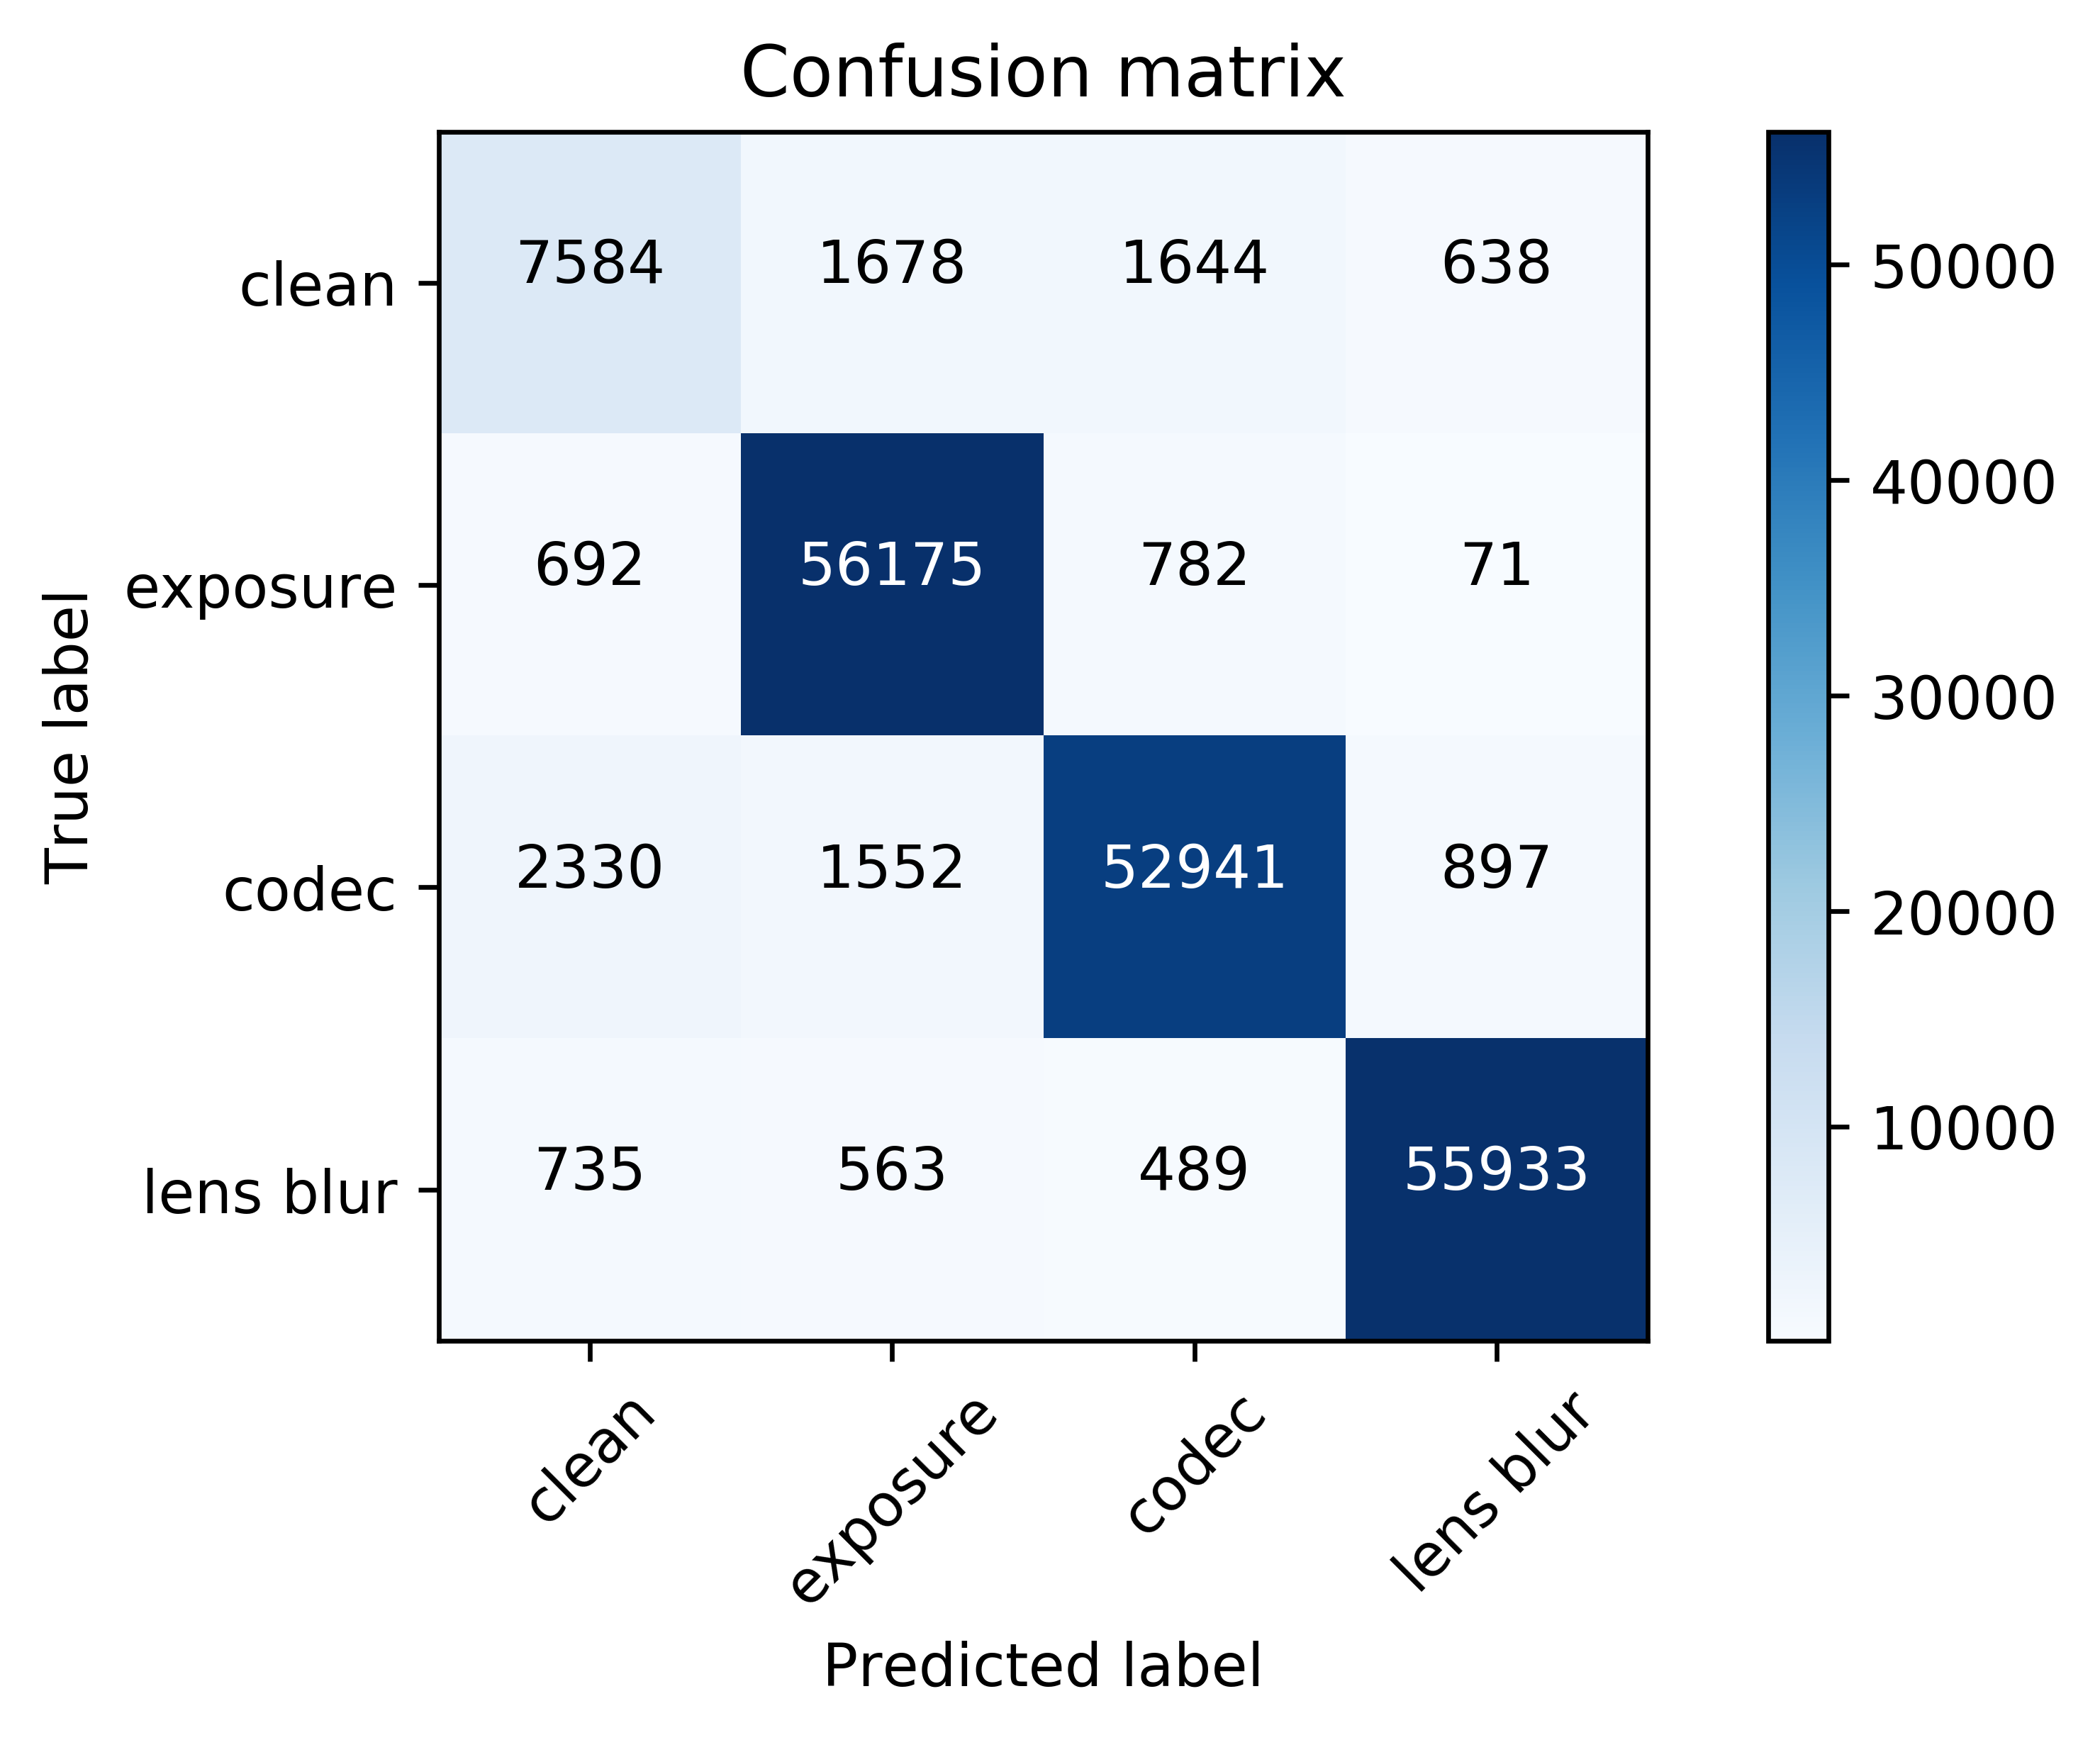

In [11]:
cure_utils.evaluate_model(gating_network_model, testloader, 4, ['clean', 'exposure', 'codec', 'lens blur'])

# Assemble complete network with pre-trained gating weights

In [20]:
mix_of_experts_model = cure_models.GroupOfExpertsShallowNetwork().cuda()
mix_of_experts_model.challenge_free.load_state_dict(torch.load('checkpoints/shallowCNN_challenge_free.41-0.973.pt')['model'], strict=False)
mix_of_experts_model.exposure.load_state_dict(torch.load('checkpoints/shallowCNN_exposure_0_3.62-0.728.pt')['model'], strict=False)
mix_of_experts_model.codec_error.load_state_dict(torch.load('checkpoints/shallowCNN_codec_error_1_3.70-0.790.pt')['model'], strict=False)
mix_of_experts_model.lens_blur.load_state_dict(torch.load('checkpoints/shallowCNN_lens_blur_all_cont.284-0.813.pt')['model'], strict=False)
mix_of_experts_model.gating_network.load_state_dict(torch.load('checkpoints/gating_network.26-0.940.pt')['model'], strict=False)

<All keys matched successfully>

In [15]:
%%time
# load all four noise classes (none, exposure, codec error, lens blur)
testdataset_paths = cure_dataset.CURETSRDataset('../data', 'Test', '*', '00', '*', transform=load_raw).paths + \
                    cure_dataset.CURETSRDataset('../data', 'Test', '*', '02', '*', transform=load_raw).paths + \
                    cure_dataset.CURETSRDataset('../data', 'Test', '*', '03', '*', transform=load_raw).paths + \
                    cure_dataset.CURETSRDataset('../data', 'Test', '*', '06', '*', transform=load_raw).paths
            
# traindataset_paths = cure_dataset.CURETSRDataset('../data', 'Train', '*', '00', '*', transform=load_raw).paths + \
#                      cure_dataset.CURETSRDataset('../data', 'Train', '*', '02', '*', transform=load_raw).paths + \
#                      cure_dataset.CURETSRDataset('../data', 'Train', '*', '03', '*', transform=load_raw).paths + \
#                      cure_dataset.CURETSRDataset('../data', 'Train', '*', '06', '*', transform=load_raw).paths

            
testdataset = cure_dataset.CURETSRDatasetCached('', '', '', '', '', fromPaths=testdataset_paths, transform=load_raw)          
# traindataset = cure_dataset.CURETSRDatasetCached('', '', '', '', '', fromPaths=traindataset_paths, transform=load_raw)          


trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=False, num_workers=0)


CPU times: user 47 s, sys: 5.1 s, total: 52.1 s
Wall time: 52.1 s


/home/ubuntu/project/cure_models.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  gate_weights = F.softmax(self.gating_network(x)).reshape(-1,4,1).expand_as(intermediate) # n,4


Confusion matrix, without normalization
[[ 9472   213   102    15   161    10    24   215   296   589   357    23
    295   372]
 [ 1306  7120   380     6    70    14    26   100   275   132   258    11
     87   199]
 [  984   401  4724     4    30     2     6   105   192   153   106    19
     94   172]
 [  304   129    15 11314   899    42    54    58   133   310    41   258
    138   417]
 [  580   119    26   225 13166    69   103    96   142   253    76   200
    141   772]
 [  110    17     4    28   219 16856     2    28    67    37    46  1227
     78    65]
 [  474    82     9    25   438    32  7083    41    53   117    45    17
    142  2738]
 [  525   199    30    11   129    23    30 11053   246   352    21    32
    124   201]
 [ 1209   333   165     4   155    10    45    88  6449   541   444    45
    224   192]
 [ 1934   314   177    11   175    33     8   176   553  7995   270    36
    293   201]
 [  800   179   347    12    47     1     3    55   612   157  4652   

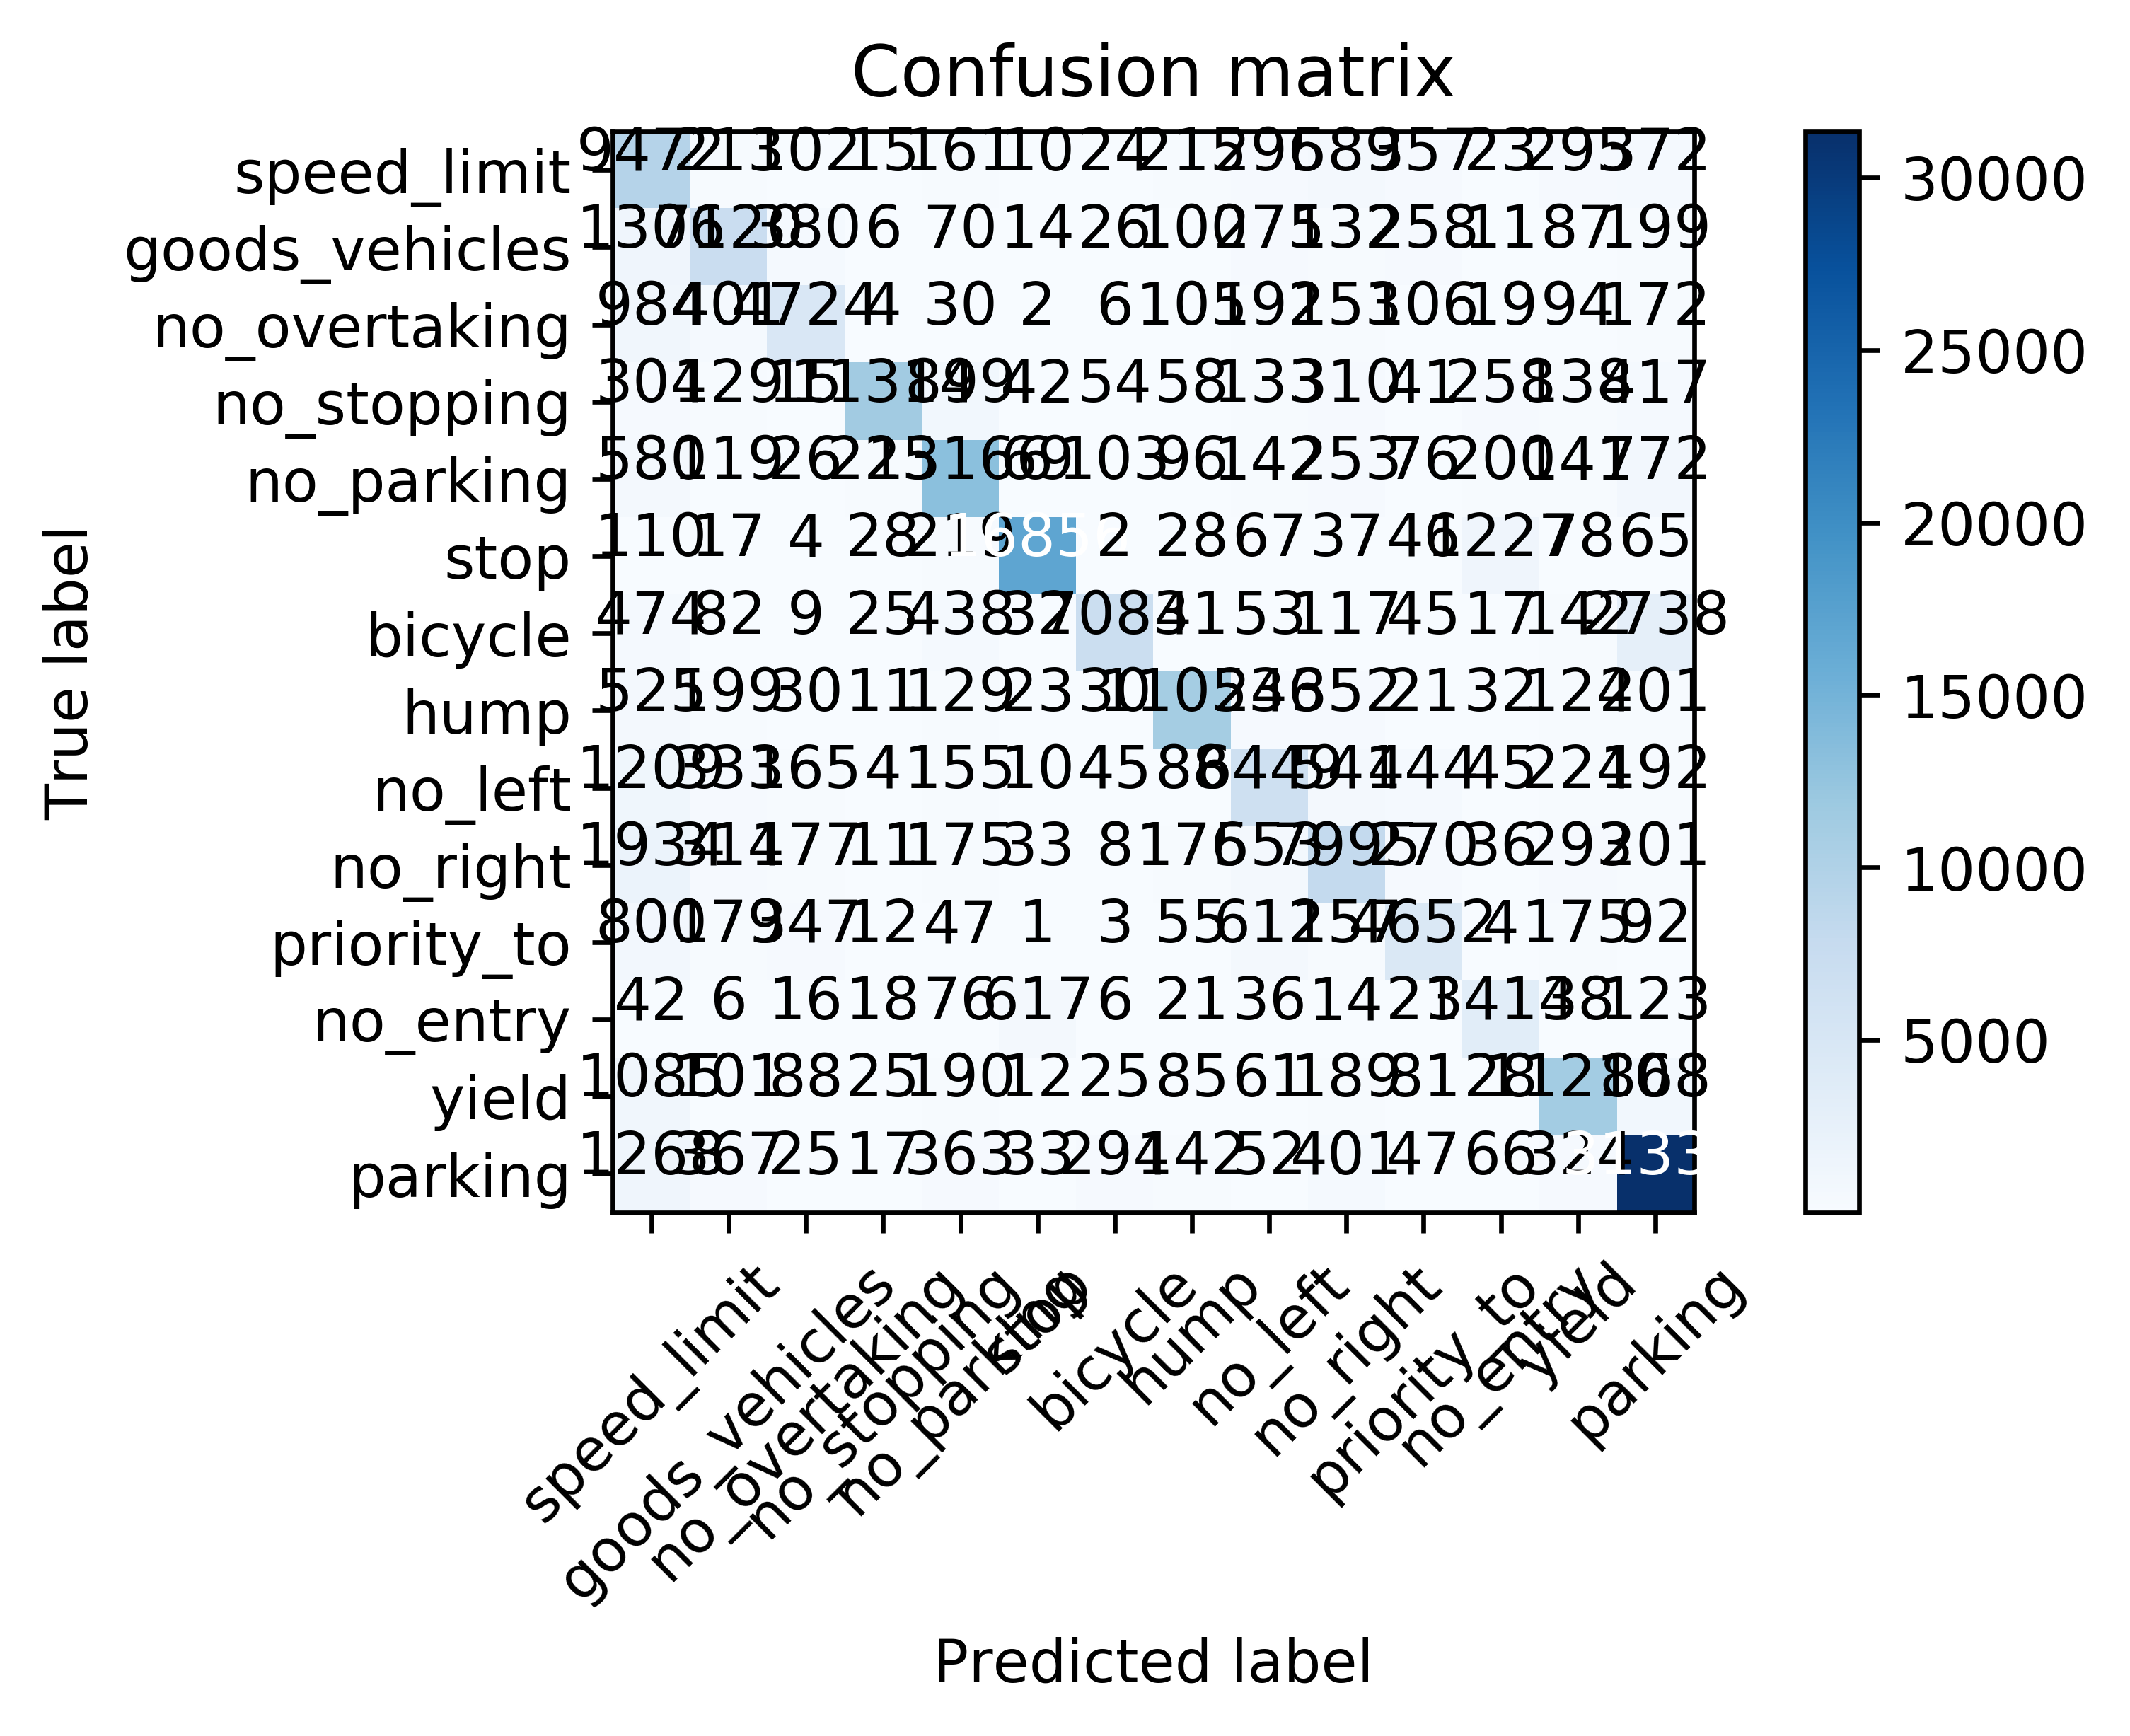

In [21]:
cure_utils.evaluate_model(mix_of_experts_model, testloader)

In [22]:
torch.save(mix_of_experts_model, 'checkpoints/mix_of_experts_raw_gating.pt')

In [24]:
torch.save(mix_of_experts_model.state_dict(), 'checkpoints/mix_of_experts_raw_gating_state_dict.pt')

In [28]:
# model overall evaluation script
# this is gonna take a while lol


challenge_types = ['06', '03', '02']
challenge_labels = ['Exposure', 'Codec Error', 'Lens Blur']

challenge_free_model = cure_models.ShallowNetwork().cuda()
exposure_model = cure_models.ShallowNetwork().cuda()
codec_error_model = cure_models.ShallowNetwork().cuda()
lens_blur_model = cure_models.ShallowNetwork().cuda()
group_of_experts_model = cure_models.GroupOfExpertsShallowNetwork().cuda()

challenge_free_model.load_state_dict(torch.load('checkpoints/shallowCNN_challenge_free.41-0.973.pt')['model'], strict=False)
exposure_model.load_state_dict(torch.load('checkpoints/shallowCNN_exposure_0_3.62-0.728.pt')['model'], strict=False)
codec_error_model.load_state_dict(torch.load('checkpoints/shallowCNN_codec_error_1_3.70-0.790.pt')['model'], strict=False)
lens_blur_model.load_state_dict(torch.load('checkpoints/shallowCNN_lens_blur_all_cont.284-0.813.pt')['model'], strict=False)
group_of_experts_model.load_state_dict(torch.load('checkpoints/mix_of_experts_raw_gating_state_dict.pt'))


models = [challenge_free_model, exposure_model, codec_error_model, lens_blur_model, group_of_experts_model]

model_labels = ['Challenge Free', 'Exposure Expert', 'Codec Error Expert', 'Lens Blur Expert', 'Group Of Experts']

In [32]:
%%time
# iterate over each challenge type and level

# len 5 vector of model results on clean data
clean_results = []
# outer layer is challenge, inner layer is challenge level, inside of which is a list of results per model
challenge_results = [
    [
        [],[],[],[],[],[]
    ],[
        [],[],[],[],[],[]
    ],[
        [],[],[],[],[],[]
    ]
]

# load clean data for baseline
testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '00', '*', transform=load_raw)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000,
                                          shuffle=False, num_workers=0)

clean_results = [cure_utils.model_acc(model, testloader) for model in models]

for idx, challenge in enumerate(challenge_types):
    challenge_results[idx][0] = clean_results
    for challenge_level in range(1,6):
        testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', challenge, '0'+str(challenge_level), transform=load_raw)
        testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000,
                                          shuffle=False, num_workers=0)
        challenge_results[idx][challenge_level] = [cure_utils.model_acc(model, testloader) for model in models]
        


CPU times: user 1min 23s, sys: 8.73 s, total: 1min 32s
Wall time: 1min 32s


In [31]:
clean_results

[0.9727130977130977,
 0.9545218295218295,
 0.9392758142758143,
 0.9015072765072765,
 0.9676888426888427]

In [34]:
results = np.array(challenge_results)

In [35]:
results.shape

(3, 6, 5)

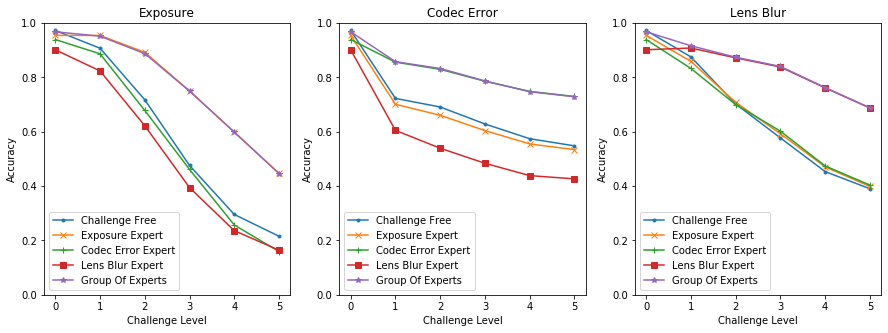

In [47]:
markers=['.','x','+','s','*']
plt.subplots(1,3, figsize=(15,5))
for challenge_idx, challenge_label in enumerate(challenge_labels):
    plt.subplot(1,3,challenge_idx+1)
    plt.title(challenge_label)
    plt.xlabel('Challenge Level')
    plt.ylabel('Accuracy')
    plt.ylim(0,1)
    for model_idx, model_label in enumerate(model_labels):
        plt.plot(np.arange(6), results[challenge_idx, :, model_idx], marker=markers[model_idx], label=model_label)
    plt.legend()

In [48]:
torch.save(results, 'preliminary_group_of_experts_results.numpy.pt')